# 🎉 Out-of-Distribution (OOD) with PCA using Deep Features from the Latent Space

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks using deep features from the latent space

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [2]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from images_standardizing import *

In [3]:
import tarfile

def extract_tgz(tgz_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
        print(f"Arquivos extraídos para {extract_to}")

tgz_path = '../CBIR_15-Scene.tgz'
extract_to = '../data/'

extract_tgz(tgz_path, extract_to)

Arquivos extraídos para ../data/


In [4]:
df = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
4480,../data/CBIR_15-Scene/14/4481.jpg,Store
4481,../data/CBIR_15-Scene/14/4482.jpg,Store
4482,../data/CBIR_15-Scene/14/4483.jpg,Store
4483,../data/CBIR_15-Scene/14/4484.jpg,Store


## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [5]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
1267,../data/CBIR_15-Scene/05/1268.jpg,Coast
1268,../data/CBIR_15-Scene/05/1269.jpg,Coast
1269,../data/CBIR_15-Scene/05/1270.jpg,Coast
1270,../data/CBIR_15-Scene/05/1271.jpg,Coast
1271,../data/CBIR_15-Scene/05/1272.jpg,Coast
...,...,...
4165,../data/CBIR_15-Scene/13/4166.jpg,Office
4166,../data/CBIR_15-Scene/13/4167.jpg,Office
4167,../data/CBIR_15-Scene/13/4168.jpg,Office
4168,../data/CBIR_15-Scene/13/4169.jpg,Office


It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [6]:
X = df_different['image_path'].tolist()
y = df_different['category'].tolist()
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Coast', 'Office']


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [7]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

Now, we should load our patches for training:

In [8]:
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))
print(training_images_by_category)

{'Coast': array([[[[105, 105, 105],
         [105, 105, 105],
         [110, 110, 110],
         ...,
         [ 69,  69,  69],
         [ 70,  70,  70],
         [ 70,  70,  70]],

        [[ 95,  95,  95],
         [ 98,  98,  98],
         [105, 105, 105],
         ...,
         [ 67,  67,  67],
         [ 68,  68,  68],
         [ 67,  67,  67]],

        [[ 96,  96,  96],
         [ 96,  96,  96],
         [ 98,  98,  98],
         ...,
         [ 67,  67,  67],
         [ 67,  67,  67],
         [ 66,  66,  66]],

        ...,

        [[ 17,  17,  17],
         [ 16,  16,  16],
         [ 18,  18,  18],
         ...,
         [ 48,  48,  48],
         [ 46,  46,  46],
         [ 44,  44,  44]],

        [[ 40,  40,  40],
         [ 33,  33,  33],
         [ 25,  25,  25],
         ...,
         [ 51,  51,  51],
         [ 50,  50,  50],
         [ 49,  49,  49]],

        [[ 45,  45,  45],
         [ 47,  47,  47],
         [ 42,  42,  42],
         ...,
         [ 53,  53,  53]

### Centering images

Now, we need to center the images to make the neural network more efficient. We are not normalizing it to avoid information loss.

In [9]:
def center_images(images):
    num_images, height, width, channels = images.shape
    flattened_images = images.reshape((num_images, -1))
    
    mean = np.mean(flattened_images, axis=0)
    
    centered_flattened_images = flattened_images - mean
    
    centered_images = centered_flattened_images.reshape((num_images, height, width, channels))
    return centered_images

centralized_images_by_category = {}
scalers_by_category = {}
for category, images in training_images_by_category.items():
    print(images.shape)
    centralized_images = center_images(images)
    centralized_images_by_category[category] = centralized_images
    print(f"Category {category}, images shape: {centralized_images.shape}")


(348, 224, 224, 3)
Category Coast, images shape: (348, 224, 224, 3)
(209, 224, 224, 3)
Category Office, images shape: (209, 224, 224, 3)


In [10]:
def check_centralization(images):
    mean = np.mean(images, axis=(0, 1, 2))
    return mean

for category, images in centralized_images_by_category.items():
    mean = check_centralization(images)
    print(f"Mean pixel values after centralization for category {category}: {mean}")


Mean pixel values after centralization for category Coast: [-2.00649119e-12 -2.00649119e-12 -2.00649119e-12]
Mean pixel values after centralization for category Office: [8.7252365e-13 8.7252365e-13 8.7252365e-13]


Given the values close to zero, it means that the pixels for each color channel are correctly centralized.

### 🏋🏽‍♂️ Training phase

With everything preprocessed, we now need to train our neural network. In this notebook, I chose the VGG16 because it's a well-known neural network that is often used por computer vision applications.

I'm using no weights, because the underlining goal of this research is to use the results from this work in a unsupervised environment.

In [11]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d


In [12]:
# Based on https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/unet.py#L19
class UNetMini(Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        # Use padding 1 to mimic `padding='same'` in keras,
        # use this visualization tool https://ezyang.github.io/convolution-visualizer/index.html
        self.block1 = Sequential(
            Conv2d(1, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)

        out = self.conv2d(out5)

        return out

Now, we get the before last layer's output to extract our latent features from the neural network.

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class FormsDataset(Dataset):
    def __init__(self, images, masks, num_classes: int, transforms=None):
        self.images = images
        self.masks = masks
        self.num_classes = num_classes
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype(np.float32)
        image = np.expand_dims(image, -1)
        image = image / 255
        if self.transforms:
            image = self.transforms(image)
            
        mask = self.masks[idx]
        mask = mask.astype(np.float32)
        mask = mask / 255
        mask[mask > .7] = 1
        mask[mask <= .7] = 0
        if self.transforms:
            mask = self.transforms(mask)
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
train_dataset = FormsDataset(train_images, train_masks, number_of_classes, get_transformations(True))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f'Train dataset has {len(train_data_loader)} batches of size {batch_size}')

NameError: name 'Model' is not defined

In [ ]:
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    #faire le preprocessing du vgg (preprocess_input)
    features = model.predict(images)
    features_by_category[category] = features

for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")

7/7 [==============================] - 17s 2s/step
Category Coast, features shape: (348, 4096)
Category Office, features shape: (209, 4096)


This result means that we extracted 348 images with 4096 features each of the Coast category and 209 images with 4096 features each of the Office category.

Now we have to reduce the dimensonality. In order to do that, we should use PCA techniques. But before that, we should centralize the features now.

In [ ]:
def centralize_data(data):
    print(data.shape)
    centralized_data = data - np.mean(data, axis=0)
    return centralized_data

centralized_features_by_category = {}

for category, features in features_by_category.items():
	centralized_features_by_category[category] = centralize_data(features)
      
print(centralized_features_by_category['Coast'].shape)
print(centralized_features_by_category['Office'].shape)

(348, 4096)
(209, 4096)
(348, 4096)
(209, 4096)


In [ ]:
# Check centralization
for category, features in centralized_features_by_category.items():
    mean_features = np.mean(features)
    print(f"Mean of centralized features for category {category}: {mean_features}")


Mean of centralized features for category Coast: -8.028643028179516e-11
Mean of centralized features for category Office: 2.361727202693231e-10


In [ ]:

pca_by_category = {}
explained_variance_by_category = {}

for category, features in centralized_features_by_category.items():
    pca = PCA(n_components=0.95) 
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, original shape: {features.shape}")
    print(f"Category {category}, principal components shape: {principal_components.shape}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")
    print(pca.components_.shape)


Category Coast, original shape: (348, 4096)
Category Coast, principal components shape: (348, 133)
Category Office, original shape: (209, 4096)
Category Office, principal components shape: (209, 132)
Category Coast, explained variance: 95.04%
(133, 4096)
Category Office, explained variance: 95.06%
(132, 4096)


The components_ matrix has the shape (n_components, n_features), but when you project the original data into this new principal components space, the data is transformed into a shape matrix (n_samples, n_components).

### Testing phase


In [ ]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size=(224,224)):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_centralized_images_by_category = {}

    for category, images in test_images_by_category.items():
        test_centralized_images = center_images(images)
        test_centralized_images_by_category[category] = test_centralized_images

    return test_centralized_images_by_category

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size=(224,224), input_size=(224,224))

In [ ]:
for category, images in centralized_images_by_category.items():
    mean = check_centralization(images)
    print(f"Mean pixel values after centralization for category {category}: {mean}")

Mean pixel values after centralization for category Coast: [-2.00649119e-12 -2.00649119e-12 -2.00649119e-12]
Mean pixel values after centralization for category Office: [8.7252365e-13 8.7252365e-13 8.7252365e-13]


In [ ]:
def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


3/3 [==============================] - 6s 2s/step


In [ ]:
# Check centralization
for category, features in test_features_by_category.items():
    mean_features = np.mean(features)
    print(f"Mean of centralized features for category {category}: {mean_features}")


Mean of centralized features for category Coast: 0.053568486124277115
Mean of centralized features for category Office: 0.06414294987916946


In [ ]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.components_
        print(principal_components.shape)
        projected_features = pca.transform(test_features)
        print(projected_features.shape)
        reconstructed_features = pca.inverse_transform(projected_features)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
        
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Coast
(133, 4096)
(140, 133)
(132, 4096)
(140, 132)
Category Coast, mean reconstruction error: 0.00802069902420044
Category Office, mean reconstruction error: 0.016001902520656586
Best category: Coast
Test category: Office
(133, 4096)
(72, 133)
(132, 4096)
(72, 132)
Category Coast, mean reconstruction error: 0.01829800382256508
Category Office, mean reconstruction error: 0.014484494924545288
Best category: Office


## Agnostic Spaces Analsys

In [ ]:
# Get the Principal Components from both categories
# First, we're going to test for "Coast" and "Office"

pca_coast = pca_by_category['Coast']
components_coast = pca_coast.components_
explained_variance_ratio_coast = pca_coast.explained_variance_ratio_


pca_office = pca_by_category['Office']
components_office = pca_office.components_
explained_variance_ratio_office = pca_office.explained_variance_ratio_

print(components_office.shape)
print(components_coast.shape)

(132, 4096)
(133, 4096)


In [ ]:
import numpy as np

components_office = pca_by_category['Office'].components_
components_coast = pca_by_category['Coast'].components_

dot_office_to_coast = []
dot_coast_to_office = []
dot_office_to_office = []
dot_coast_to_coast = []

for component_office in components_office:
    dot_products = np.dot(components_coast, component_office)
    dot_office_to_coast.append(dot_products)

dot_office_to_coast = np.array(dot_office_to_coast)
print("Dot products (Office -> Coast):")
print(dot_office_to_coast)

for component_coast in components_coast:
    dot_products = np.dot(components_office, component_coast)
    dot_coast_to_office.append(dot_products)

dot_coast_to_office = np.array(dot_coast_to_office)
print("Dot products (Coast -> Office):")
print(dot_coast_to_office)

for component_office in components_office:
    dot_products = np.dot(components_office, component_office)
    dot_office_to_office.append(dot_products)

dot_office_to_office = np.array(dot_office_to_office)
print("Dot products (Office -> Office):")
print(dot_office_to_office)

# Calculando as normas dos produtos escalares (Coast -> Coast)
for component_coast in components_coast:
    dot_products = np.dot(components_coast, component_coast)
    dot_coast_to_coast.append(dot_products)

dot_coast_to_coast = np.array(dot_coast_to_coast)
print("Dot products (Coast -> Coast):")
print(dot_coast_to_coast)


Dot products (Office -> Coast):
[[ 9.6298110e-01 -1.4682624e-01  2.2373730e-02 ... -9.0731564e-04
  -3.3668159e-03 -1.5767047e-03]
 [-7.6778159e-02 -8.8679934e-01 -9.8156072e-02 ...  1.3100037e-03
  -2.4642409e-03 -1.2746466e-03]
 [-2.5605964e-02  4.5614965e-02  1.2550268e-01 ... -2.6482502e-02
   4.6204142e-03  2.4675367e-02]
 ...
 [ 5.3116349e-03 -8.2725175e-03 -1.0694349e-02 ... -2.6238680e-02
   2.0138731e-02  3.3894230e-02]
 [ 9.7042823e-04  5.1647276e-03  2.2126846e-03 ... -2.2801103e-02
  -3.1160435e-02  9.0356759e-04]
 [ 1.5790798e-03 -6.2432478e-04  1.5820025e-02 ...  6.8912953e-03
   3.7980616e-02 -1.5314835e-02]]
Dot products (Coast -> Office):
[[ 9.6298110e-01 -7.6778159e-02 -2.5605964e-02 ...  5.3116349e-03
   9.7042823e-04  1.5790798e-03]
 [-1.4682624e-01 -8.8679934e-01  4.5614965e-02 ... -8.2725175e-03
   5.1647276e-03 -6.2432478e-04]
 [ 2.2373730e-02 -9.8156072e-02  1.2550268e-01 ... -1.0694349e-02
   2.2126846e-03  1.5820025e-02]
 ...
 [-9.0731564e-04  1.3100037e-03 -2

In [ ]:
# Recalculating the relevance scores
def calculate_relevance_scores_dot(features, components):
    dot_products = np.dot(features, components.T)
    mean_abs_dot_products = np.mean(dot_products, axis=0)
    return mean_abs_dot_products

# Calculate relevance scores for Office and Coast categories
relevance_scores_office = calculate_relevance_scores_dot(test_features_by_category['Office'], components_office)
relevance_scores_coast = calculate_relevance_scores_dot(test_features_by_category['Coast'], components_coast)

# Plotting the relevance scores
plt.figure(figsize=(12, 6))

# Relevance scores for Office
plt.subplot(1, 2, 1)
plt.plot(range(len(relevance_scores_office)), relevance_scores_office, marker='o', color='blue')
plt.title('Relevance Scores for Office Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

# Relevance scores for Coast
plt.subplot(1, 2, 2)
plt.plot(range(len(relevance_scores_coast)), relevance_scores_coast, marker='o', color='green')
plt.title('Relevance Scores for Coast Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.tight_layout()
plt.show()


NameError: name 'test_features_by_category' is not defined

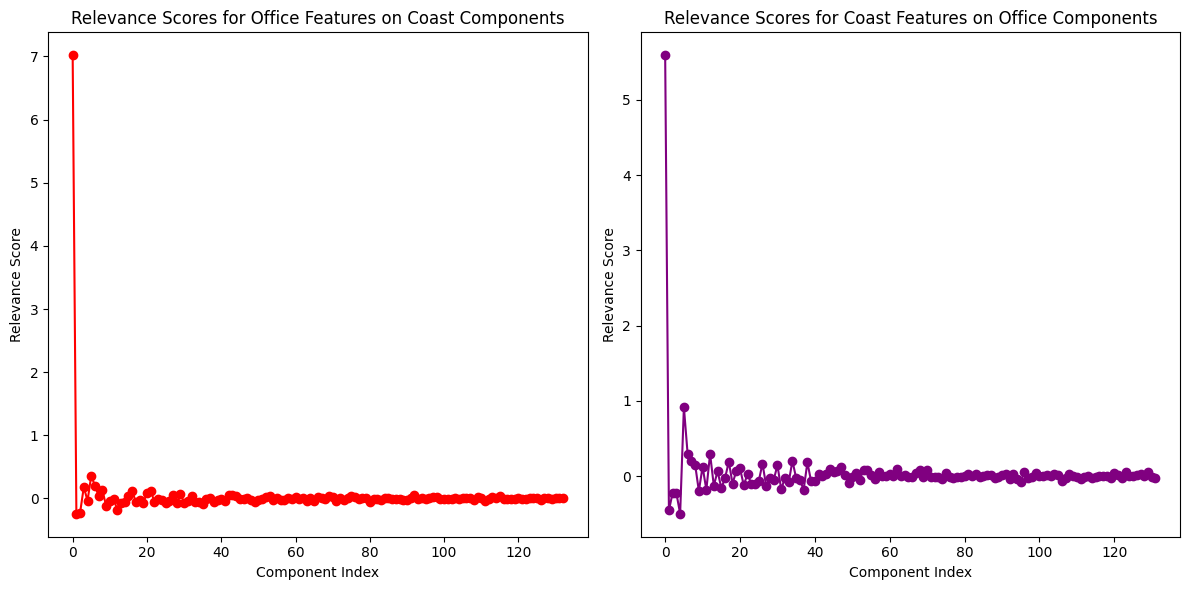

In [ ]:
relevance_scores_office_to_coast = calculate_relevance_scores_dot(test_features_by_category['Office'], components_coast)
relevance_scores_coast_to_office = calculate_relevance_scores_dot(test_features_by_category['Coast'], components_office)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(relevance_scores_office_to_coast)), relevance_scores_office_to_coast, marker='o', color='red')
plt.title('Relevance Scores for Office Features on Coast Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.subplot(1, 2, 2)
plt.plot(range(len(relevance_scores_coast_to_office)), relevance_scores_coast_to_office, marker='o', color='purple')
plt.title('Relevance Scores for Coast Features on Office Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.tight_layout()
plt.show()


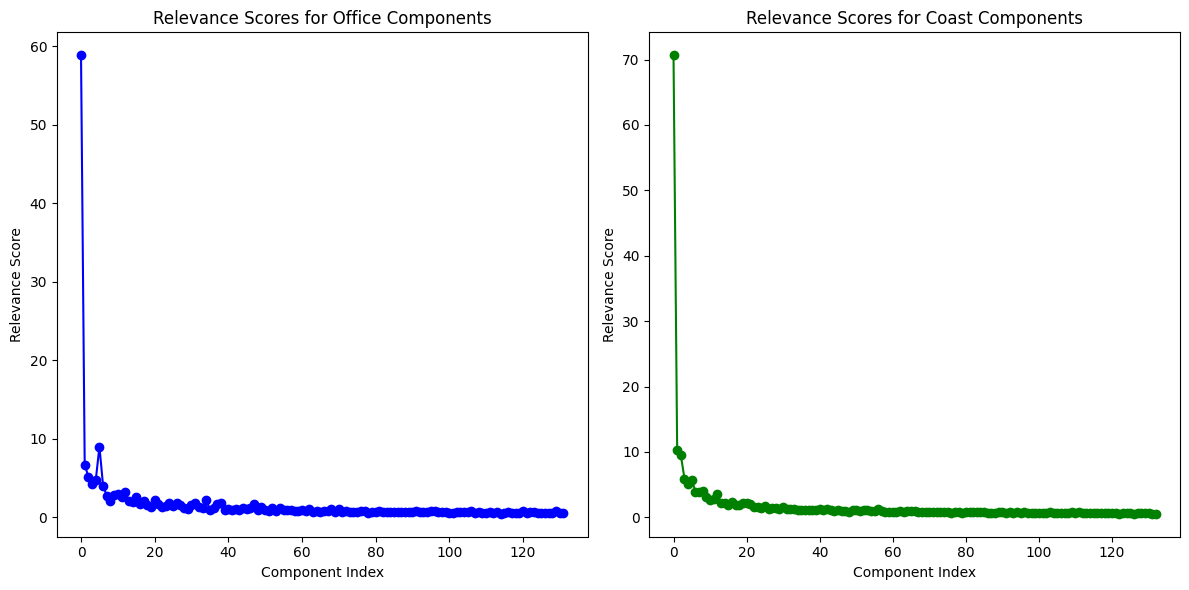

In [ ]:
# Recalculating the relevance scores
def calculate_relevance_scores_norms(features, components):
    dot_products = np.dot(features, components.T)
    norms = np.linalg.norm(dot_products, axis=0)  # Calcula a norma para cada componente
    return norms

# Calculate relevance scores for Office and Coast categories
relevance_scores_office = calculate_relevance_scores_norms(test_features_by_category['Office'], components_office)
relevance_scores_coast = calculate_relevance_scores_norms(test_features_by_category['Coast'], components_coast)

# Plotting the relevance scores
plt.figure(figsize=(12, 6))

# Relevance scores for Office
plt.subplot(1, 2, 1)
plt.plot(range(len(relevance_scores_office)), relevance_scores_office, marker='o', color='blue')
plt.title('Relevance Scores for Office Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

# Relevance scores for Coast
plt.subplot(1, 2, 2)
plt.plot(range(len(relevance_scores_coast)), relevance_scores_coast, marker='o', color='green')
plt.title('Relevance Scores for Coast Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.tight_layout()
plt.show()


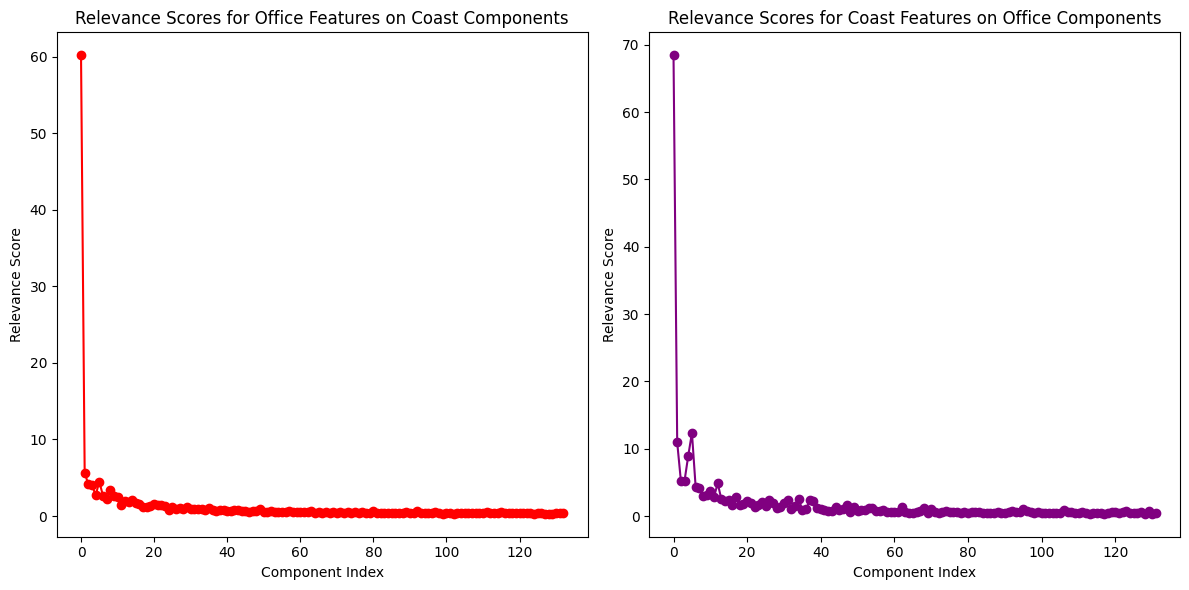

In [ ]:
relevance_scores_office_to_coast = calculate_relevance_scores_norms(test_features_by_category['Office'], components_coast)
relevance_scores_coast_to_office = calculate_relevance_scores_norms(test_features_by_category['Coast'], components_office)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(relevance_scores_office_to_coast)), relevance_scores_office_to_coast, marker='o', color='red')
plt.title('Relevance Scores for Office Features on Coast Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.subplot(1, 2, 2)
plt.plot(range(len(relevance_scores_coast_to_office)), relevance_scores_coast_to_office, marker='o', color='purple')
plt.title('Relevance Scores for Coast Features on Office Components')
plt.xlabel('Component Index')
plt.ylabel('Relevance Score')

plt.tight_layout()
plt.show()


In [ ]:
norms_of_means_coast = []

for component in components_coast:
    dot_products = np.dot(components_office, component)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    mean_dot_product = np.mean(dot_products)
    norms_of_means_coast.append(norm_of_mean)

norms_of_means_coast = np.array(norms_of_means_coast)

norms_of_means_coast_coast = []

for component in components_coast:
    dot_products = np.dot(components_coast, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_coast_coast.append(norm_of_mean)

norms_of_means_coast_coast = np.array(norms_of_means_coast_coast)

norms_of_means_office = []

for component in components_office:
    dot_products = np.dot(components_coast, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_office.append(norm_of_mean)

norms_of_means_office = np.array(norms_of_means_office)

norms_of_means_office_office = []

for component in components_office:
    dot_products = np.dot(components_office, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_office_office.append(norm_of_mean)

norms_of_means_office_office = np.array(norms_of_means_office_office)

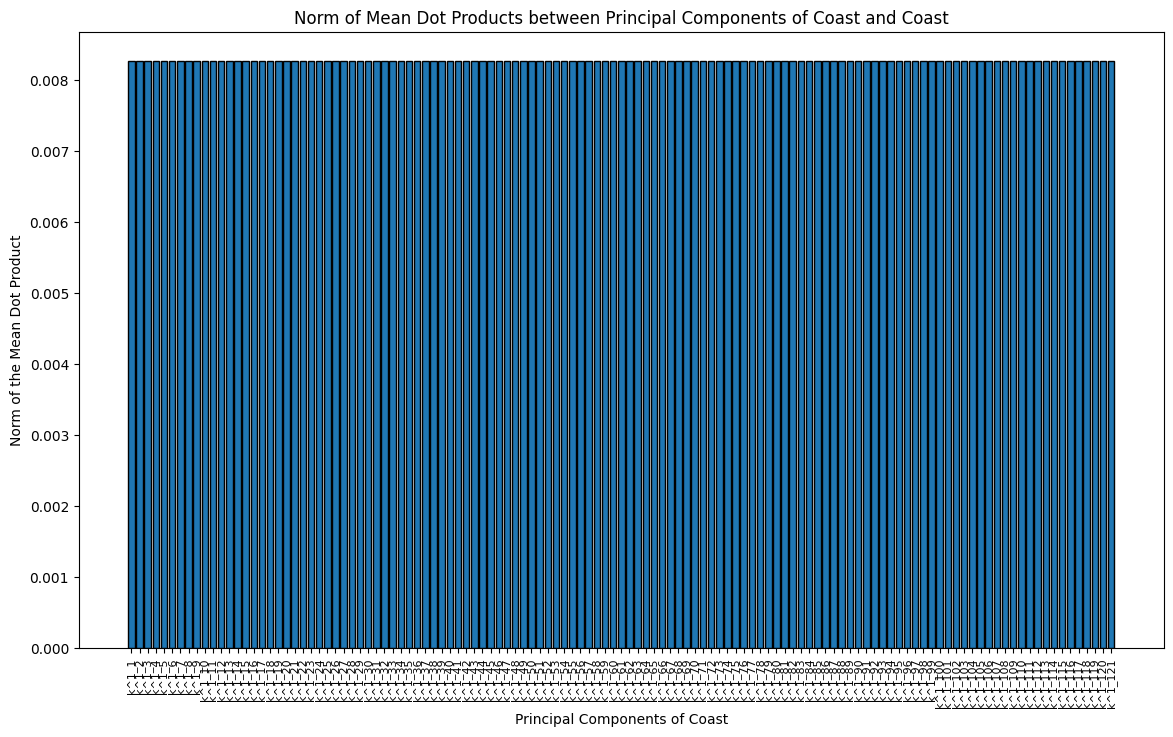

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_coast))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_coast_coast, edgecolor='black')
plt.xlabel('Principal Components of Coast')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Coast and Coast')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


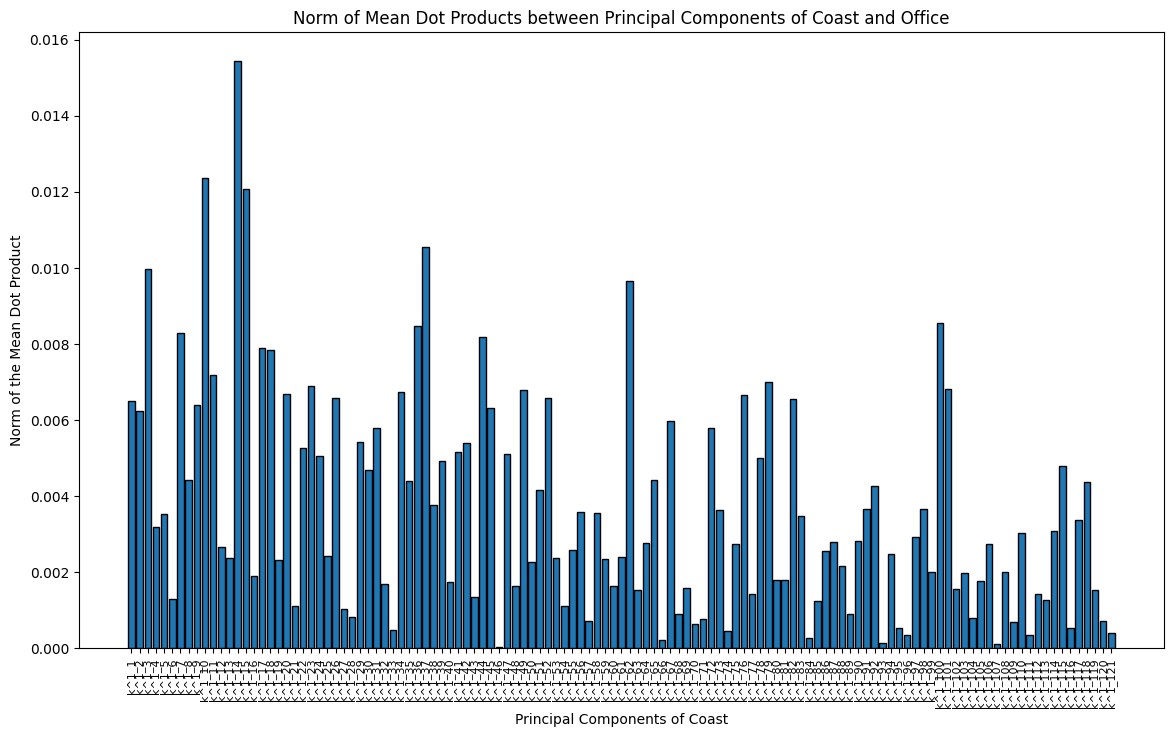

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_coast))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_coast, edgecolor='black')
plt.xlabel('Principal Components of Coast')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Coast and Office')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


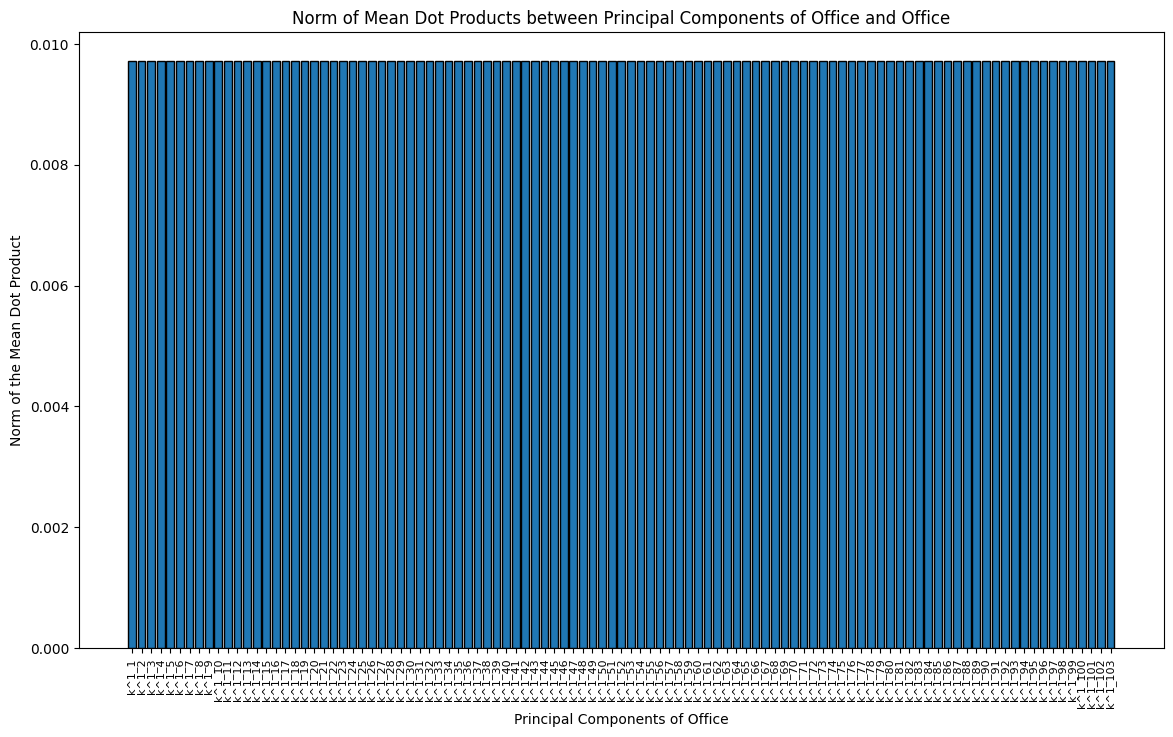

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_office))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_office_office, edgecolor='black')
plt.xlabel('Principal Components of Office')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Office and Office')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


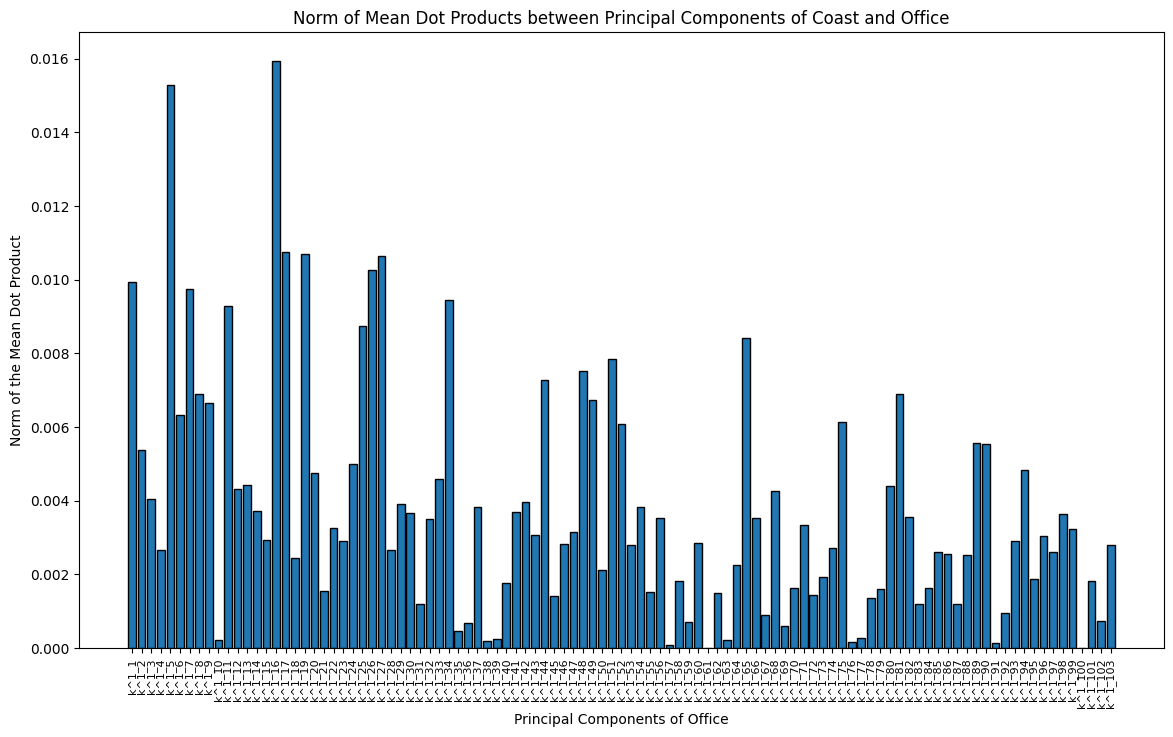

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_office))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_office, edgecolor='black')
plt.xlabel('Principal Components of Office')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Coast and Office')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


In [ ]:
threshold_percentile = 10

threshold_value_coast = np.percentile(norms_of_means_coast, threshold_percentile)
threshold_value_office = np.percentile(norms_of_means_office, threshold_percentile)

# Get the indices with the smallest values
specific_indices_coast = np.where(norms_of_means_coast <= threshold_value_coast)[0]
specific_indices_office = np.where(norms_of_means_office <= threshold_value_office)[0]

print("Specific Indices for Coast:", specific_indices_coast + 1)
print("Specific Indices for Office:", specific_indices_office + 1)

Specific Indices for Coast: [ 33  46  66  70  74  84  93  95  96 107 111 116 121]
Specific Indices for Office: [ 10  35  38  39  57  61  63  76  77  91 100]


In [ ]:
test_coast_features = test_features_by_category['Coast']
test_office_features = test_features_by_category['Office']

print(test_coast_features.shape)
print(test_office_features.shape)

(140, 4096)
(72, 4096)


In [ ]:
specific_components_coast = pca_coast.components_[specific_indices_coast]
specific_components_office = pca_office.components_[specific_indices_office]

for i, index in enumerate(specific_indices_coast):
    print(f"Component {index + 1}: {np.array_equal(components_coast[index], specific_components_coast[i])}")

print("==================")

for i, index in enumerate(specific_indices_office):
    print(f"Component {index + 1}: {np.array_equal(components_office[index], specific_components_office[i])}")


Component 33: True
Component 46: True
Component 66: True
Component 70: True
Component 74: True
Component 84: True
Component 93: True
Component 95: True
Component 96: True
Component 107: True
Component 111: True
Component 116: True
Component 121: True
Component 10: True
Component 35: True
Component 38: True
Component 39: True
Component 57: True
Component 61: True
Component 63: True
Component 76: True
Component 77: True
Component 91: True
Component 100: True


In [ ]:
def project_and_reconstruct(original_features, specific_components):
    # Flatten the original features
    flattened_features = np.array([feature.flatten() for feature in original_features])
    
    # Project the data into the specific components
    projected_features = np.dot(flattened_features, specific_components.T)
    
    # Reconstruct the features
    reconstructed_features = np.dot(projected_features, specific_components)
    
    # Reshape the reconstructed features into the original shape
    reconstructed_features = reconstructed_features.reshape(original_features.shape)
    
    return reconstructed_features

reconstructed_test_coast_coast_images = project_and_reconstruct(test_coast_features, specific_components_coast)
reconstructed_test_coast_office_images = project_and_reconstruct(test_coast_features, specific_components_office)

print("Reconstructed Test Coast Images (using Coast components):", reconstructed_test_coast_coast_images)
print("Reconstructed Test Coast Images (using Coast components):", reconstructed_test_coast_coast_images.shape)
print("Reconstructed Test Coast Images (using Office components):", reconstructed_test_coast_office_images)
print("Reconstructed Test Coast Images (using Office components):", reconstructed_test_coast_office_images.shape)

reconstructed_test_office_coast_images = project_and_reconstruct(test_office_features, specific_components_coast)
reconstructed_test_office_office_images = project_and_reconstruct(test_office_features, specific_components_office)

print("Reconstructed Test Office Images (using Coast components):", reconstructed_test_office_coast_images)
print("Reconstructed Test Office Images (using Coast components):", reconstructed_test_office_coast_images.shape)
print("Reconstructed Test Office Images (using Office components):", reconstructed_test_office_office_images)
print("Reconstructed Test Office Images (using Office components):", reconstructed_test_office_office_images.shape)


Reconstructed Test Coast Images (using Coast components): [[ 0.0002515   0.00239979 -0.00186509 ...  0.          0.
   0.00031403]
 [ 0.00184614  0.00878293 -0.00860424 ...  0.          0.
  -0.00856557]
 [-0.01866964  0.00244267 -0.00766187 ...  0.          0.
  -0.01021776]
 ...
 [ 0.00791653 -0.00449752  0.00265736 ...  0.          0.
   0.00722123]
 [ 0.00924525 -0.00203688  0.01360882 ...  0.          0.
  -0.00167949]
 [-0.01552631  0.00906052 -0.01034349 ...  0.          0.
  -0.00752116]]
Reconstructed Test Coast Images (using Coast components): (140, 4096)
Reconstructed Test Coast Images (using Office components): [[-0.01138313  0.01255133 -0.02313059 ...  0.          0.
  -0.00033922]
 [-0.03494357  0.02977801 -0.03130776 ...  0.          0.
  -0.00097886]
 [-0.01349196  0.01175175 -0.02094277 ...  0.          0.
  -0.00018014]
 ...
 [-0.01953604  0.02133075 -0.02497123 ...  0.          0.
   0.0021792 ]
 [-0.03732495  0.03267552 -0.0335952  ...  0.          0.
   0.00258621]

In [ ]:
residuals_coast_coast = test_coast_features - reconstructed_test_coast_coast_images
residuals_coast_office = test_coast_features - reconstructed_test_coast_office_images

residuals_office_coast = test_office_features - reconstructed_test_office_office_images
residuals_office_office = test_office_features - reconstructed_test_office_office_images

# Print residuals
print("Residuals Coast-Coast:", residuals_coast_coast)
print("Residuals Coast-Office:", residuals_coast_office)
print("Residuals Office-Coast:", residuals_office_coast)
print("Residuals Office-Office:", residuals_office_office)

Residuals Coast-Coast: [[0.1987682  0.15655454 0.1674158  ... 0.         0.         0.19563943]
 [0.03804521 0.13856943 0.1746738  ... 0.         0.         0.00856557]
 [0.08561285 0.27911758 0.03385863 ... 0.         0.         0.08645748]
 ...
 [0.11835704 0.15033866 0.00829935 ... 0.         0.         0.14790966]
 [0.03858786 0.06874438 0.07280103 ... 0.         0.         0.16022477]
 [0.06763808 0.17862283 0.06788699 ... 0.         0.         0.09987568]]
Residuals Coast-Office: [[0.21040283 0.146403   0.18868129 ... 0.         0.         0.19629267]
 [0.07483491 0.11757436 0.19737732 ... 0.         0.         0.00097886]
 [0.08043518 0.26980853 0.04713953 ... 0.         0.         0.07641986]
 ...
 [0.1458096  0.12451039 0.03592794 ... 0.         0.         0.1529517 ]
 [0.08515806 0.03403197 0.12000506 ... 0.         0.         0.15595905]
 [0.08550371 0.15616225 0.09538704 ... 0.         0.         0.08640007]]
Residuals Office-Coast: [[0.20715642 0.32346845 0.26285893 ... 0.

In [ ]:
def calculate_ood(original_features, residuals):
    residual_norms = np.linalg.norm(residuals, axis=1)
    original_norms = np.linalg.norm(original_features, axis=1)
    ood_scores = residual_norms / original_norms
    return ood_scores

In [ ]:

# Calculate OOD scores
ood_scores_coast_coast = calculate_ood(test_coast_features, residuals_coast_coast)
ood_scores_coast_office = calculate_ood(test_coast_features, residuals_coast_office)

ood_scores_office_coast = calculate_ood(test_office_features, residuals_office_coast)
ood_scores_office_office = calculate_ood(test_office_features, residuals_office_office)

# Print OOD scores
print("OOD Scores Coast-Coast:", ood_scores_coast_coast)
print("OOD Scores Coast-Office:", ood_scores_coast_office)
print("OOD Scores Office-Office:", ood_scores_office_office)
print("OOD Scores Office-Coast:", ood_scores_office_coast)



OOD Scores Coast-Coast: [0.9995747  0.9990308  0.99890167 0.9994277  0.99940944 0.99954283
 0.9992156  0.9992707  0.9989089  0.9991965  0.99940217 0.9992143
 0.99896055 0.99751294 0.99920094 0.9973483  0.9996512  0.99890953
 0.99901605 0.99811935 0.9992578  0.99871665 0.99925274 0.99958843
 0.99905115 0.9981993  0.99935585 0.99939764 0.99856824 0.9994402
 0.9988665  0.9989775  0.99898773 0.99923295 0.9995132  0.9996762
 0.99859494 0.9998033  0.99936473 0.9985639  0.9997498  0.99965614
 0.99904835 0.99945533 0.99955523 0.9994365  0.9989939  0.99909455
 0.99959564 0.99921685 0.99955493 0.9989981  0.9995592  0.9996635
 0.99941975 0.99845225 0.9993449  0.99909645 0.99832076 0.99932706
 0.99783885 0.99970806 0.9991763  0.9995075  0.99964255 0.99947095
 0.9992701  0.9989959  0.9995751  0.99956536 0.9996699  0.99905825
 0.9993761  0.9977772  0.99880636 0.9994427  0.9984571  0.9986716
 0.99932766 0.99963945 0.9988938  0.9989834  0.99945015 0.99883795
 0.99972    0.9973953  0.99896914 0.999073 

In [ ]:
# Aggregate OOD scores
ood_scores_coast = {
    'Coast-Coast': np.mean(ood_scores_coast_coast),
    'Coast-Office': np.mean(ood_scores_coast_office)
}
ood_scores_office = {
    'Office-Office': np.mean(ood_scores_office_office),
    'Office-Coast': np.mean(ood_scores_office_coast)
}

# Determine the best environment for each test set
best_environment_coast = min(ood_scores_coast, key=ood_scores_coast.get)
best_environment_office = min(ood_scores_office, key=ood_scores_office.get)

print(f"OOD scores (COAST TEST): {ood_scores_coast}")
print(f"Best environment (COAST TEST): {best_environment_coast}")

print(f"OOD scores (OFFICE TEST): {ood_scores_office}")
print(f"Best environment (OFFICE TEST): {best_environment_office}")

OOD scores (COAST TEST): {'Coast-Coast': 0.999047, 'Coast-Office': 0.99303526}
Best environment (COAST TEST): Coast-Office
OOD scores (OFFICE TEST): {'Office-Office': 0.99159175, 'Office-Coast': 0.99159175}
Best environment (OFFICE TEST): Office-Office


## Mahalanobis Distance Analysis

In [ ]:
from scipy.spatial.distance import mahalanobis

def calculate_mahalanobis_distance(features, mean, cov_inv):
    distances = []
    for feature in features:
        distance = mahalanobis(feature, mean, cov_inv)
        distances.append(distance)
    return np.array(distances)

def calculate_mean_cov(features):
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    cov += np.eye(cov.shape[0])
    cov_inv = np.linalg.inv(cov)
    return mean, cov_inv

train_coast_features = features_by_category['Coast']
train_office_features = features_by_category['Office']

mean_coast, cov_inv_coast = calculate_mean_cov(train_coast_features)
mean_office, cov_inv_office = calculate_mean_cov(train_office_features)

mahalanobis_distances_coast_coast = calculate_mahalanobis_distance(test_coast_features, mean_coast, cov_inv_coast)
mahalanobis_distances_coast_office = calculate_mahalanobis_distance(test_coast_features, mean_office, cov_inv_office)

mahalanobis_distances_office_office = calculate_mahalanobis_distance(test_office_features, mean_office, cov_inv_office)
mahalanobis_distances_office_coast = calculate_mahalanobis_distance(test_office_features, mean_coast, cov_inv_coast)


In [ ]:
ood_scores_coast_mahalanobis = {
    'Coast-Coast': np.mean(mahalanobis_distances_coast_coast),
    'Coast-Office': np.mean(mahalanobis_distances_coast_office)
}
ood_scores_office_mahalanobis = {
    'Office-Office': np.mean(mahalanobis_distances_office_office),
    'Office-Coast': np.mean(mahalanobis_distances_office_coast)
}

best_environment_coast = min(ood_scores_coast_mahalanobis, key=ood_scores_coast_mahalanobis.get)
best_environment_office = min(ood_scores_office_mahalanobis, key=ood_scores_office_mahalanobis.get)

print(f"OOD scores (COAST TEST) MAHALANOBIS: {ood_scores_coast_mahalanobis}")
print(f"Best environment (COAST TEST): {best_environment_coast}")

print(f"OOD scores (OFFICE TEST) MAHALANOBIS: {ood_scores_office_mahalanobis}")
print(f"Best environment (OFFICE TEST): {best_environment_office}")

OOD scores (COAST TEST) MAHALANOBIS: {'Coast-Coast': 2.0660014352401217, 'Coast-Office': 2.2707090605943487}
Best environment (COAST TEST): Coast-Coast
OOD scores (OFFICE TEST) MAHALANOBIS: {'Office-Office': 2.1786052260805224, 'Office-Coast': 2.337053478826559}
Best environment (OFFICE TEST): Office-Office


## ✌️ Part II: Comparing two similar environments

In [ ]:
train_categories = ['Bedroom', 'LivingRoom']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
1262,../data/CBIR_15-Scene/04/1263.jpg,LivingRoom
1263,../data/CBIR_15-Scene/04/1264.jpg,LivingRoom
1264,../data/CBIR_15-Scene/04/1265.jpg,LivingRoom
1265,../data/CBIR_15-Scene/04/1266.jpg,LivingRoom


In [ ]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)

image_size = (224, 224)
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")


Unique categories: ['Bedroom', 'LivingRoom']


In [ ]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [ ]:
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))
print(training_images_by_category)

{'Bedroom': array([[[[218, 218, 218],
         [222, 222, 222],
         [224, 224, 224],
         ...,
         [210, 210, 210],
         [225, 225, 225],
         [225, 225, 225]],

        [[195, 195, 195],
         [198, 198, 198],
         [197, 197, 197],
         ...,
         [235, 235, 235],
         [255, 255, 255],
         [255, 255, 255]],

        [[168, 168, 168],
         [162, 162, 162],
         [168, 168, 168],
         ...,
         [238, 238, 238],
         [255, 255, 255],
         [254, 254, 254]],

        ...,

        [[174, 174, 174],
         [182, 182, 182],
         [183, 183, 183],
         ...,
         [183, 183, 183],
         [185, 185, 185],
         [204, 204, 204]],

        [[192, 192, 192],
         [196, 196, 196],
         [195, 195, 195],
         ...,
         [249, 249, 249],
         [249, 249, 249],
         [252, 252, 252]],

        [[239, 239, 239],
         [248, 248, 248],
         [248, 248, 248],
         ...,
         [254, 254, 25

In [ ]:
centralized_images_by_category = {}
scalers_by_category = {}
for category, images in training_images_by_category.items():
    centralized_images = center_images(images)
    centralized_images_by_category[category] = centralized_images


In [ ]:
preprocessed_images_by_category = {}
preprocessed_images_by_category = centralized_images_by_category

for category, images in preprocessed_images_by_category.items():
    print(f"Categoria {category}, images shape: {images.shape}")

Categoria Bedroom, images shape: (207, 224, 224, 3)
Categoria LivingRoom, images shape: (278, 224, 224, 3)


Categoria Bedroom, images shape: (207, 224, 224, 3)


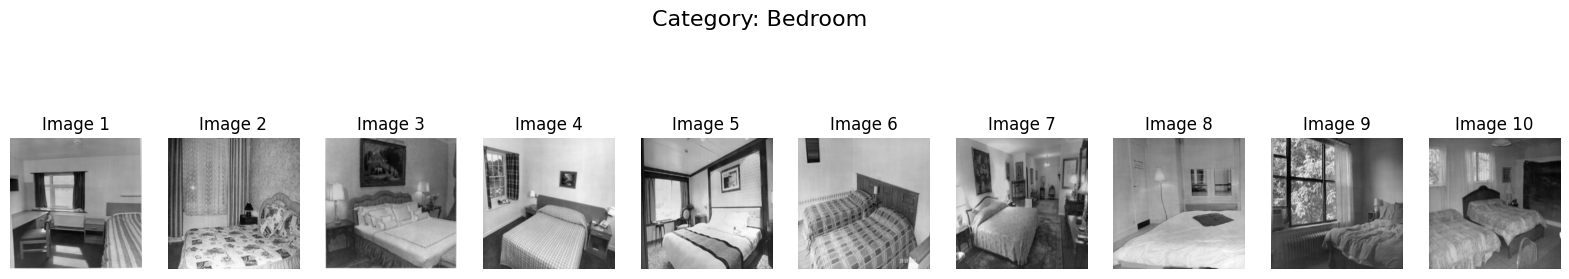

Categoria LivingRoom, images shape: (278, 224, 224, 3)


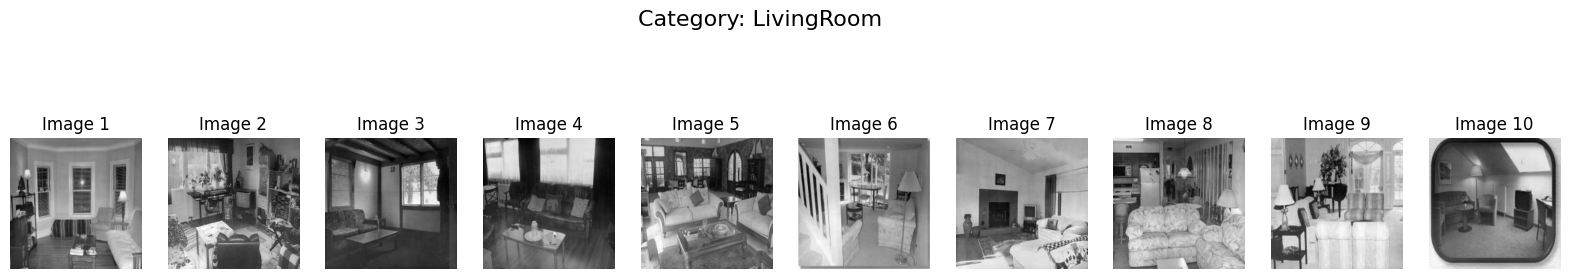

In [ ]:
# Visualizar os dados pré-processados
num_images_to_show = 10

for category, images in preprocessed_images_by_category.items():
    print(f"Categoria {category}, images shape: {images.shape}")
    
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
    fig.suptitle(f"Category: {category}", fontsize=16)
    for i in range(num_images_to_show):
        image = images[i]
        image = (image - image.min()) / (image.max() - image.min())  # Normalizar para [0, 1]
        axes[i].imshow(image)
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    plt.show()

In [ ]:
base_model = VGG16(weights=None, include_top=True)

In [ ]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [ ]:
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    features = model.predict(images)
    features_by_category[category] = features

for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")

9/9 [==============================] - 21s 2s/step
Category Bedroom, features shape: (207, 4096)
Category LivingRoom, features shape: (278, 4096)


Categoria Bedroom, features shape: (207, 4096)


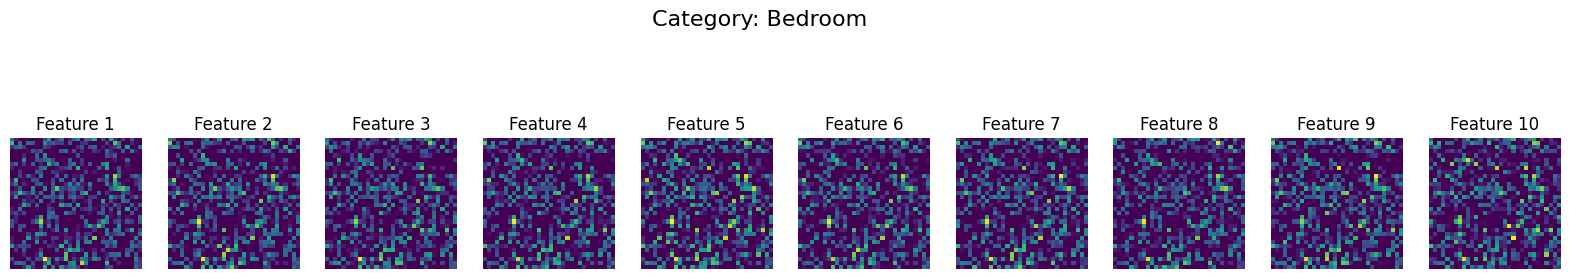

Categoria LivingRoom, features shape: (278, 4096)


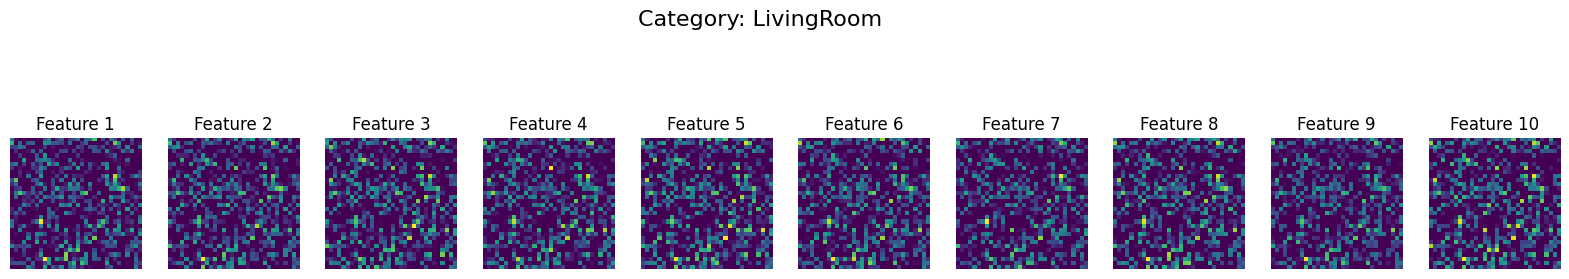

In [ ]:
# Número de componentes a visualizar para cada categoria
num_features_to_show = 10

# Visualizar as características extraídas
for category, features in features_by_category.items():
    print(f"Categoria {category}, features shape: {features.shape}")
    
    fig, axes = plt.subplots(1, num_features_to_show, figsize=(20, 4))
    fig.suptitle(f"Category: {category}", fontsize=16)
    for i in range(num_features_to_show):
        feature_vector = features[i]
        feature_image = feature_vector[:1024].reshape((32, 32))  # Ajustar o reshape conforme necessário
        axes[i].imshow(feature_image, cmap='viridis')
        axes[i].set_title(f'Feature {i+1}')
        axes[i].axis('off')

    plt.show()


Verifying features for category: Bedroom
Shape of features: (207, 4096)
Mean of features (should be close to 0 if centralized): [-7.7673199e-08 -2.7966673e-08 -1.3677395e-09  1.3989522e-11
  0.0000000e+00  0.0000000e+00 -1.1715768e-08 -7.6485429e-11
  7.6305460e-09 -4.5495334e-08]
Variance of features: [5.1907590e-03 2.0372779e-03 2.8934216e-04 5.9595823e-07 0.0000000e+00
 0.0000000e+00 2.6187797e-03 6.9380681e-06 4.0604873e-03 5.9186928e-03]
Verifying features for category: LivingRoom
Shape of features: (278, 4096)
Mean of features (should be close to 0 if centralized): [ 2.8006680e-08  1.1376875e-08  1.2462302e-09  0.0000000e+00
 -6.0144424e-11  0.0000000e+00  1.6670004e-08 -2.1566148e-11
 -7.1691737e-09 -9.2730247e-08]
Variance of features: [4.2505441e-03 1.7409398e-03 3.6224400e-04 0.0000000e+00 1.1884508e-06
 0.0000000e+00 2.7382111e-03 2.0425223e-06 3.0124257e-03 5.1002507e-03]
Explained variance ratio for category Bedroom (first 10 components): [0.3442963  0.08931351 0.06582332 

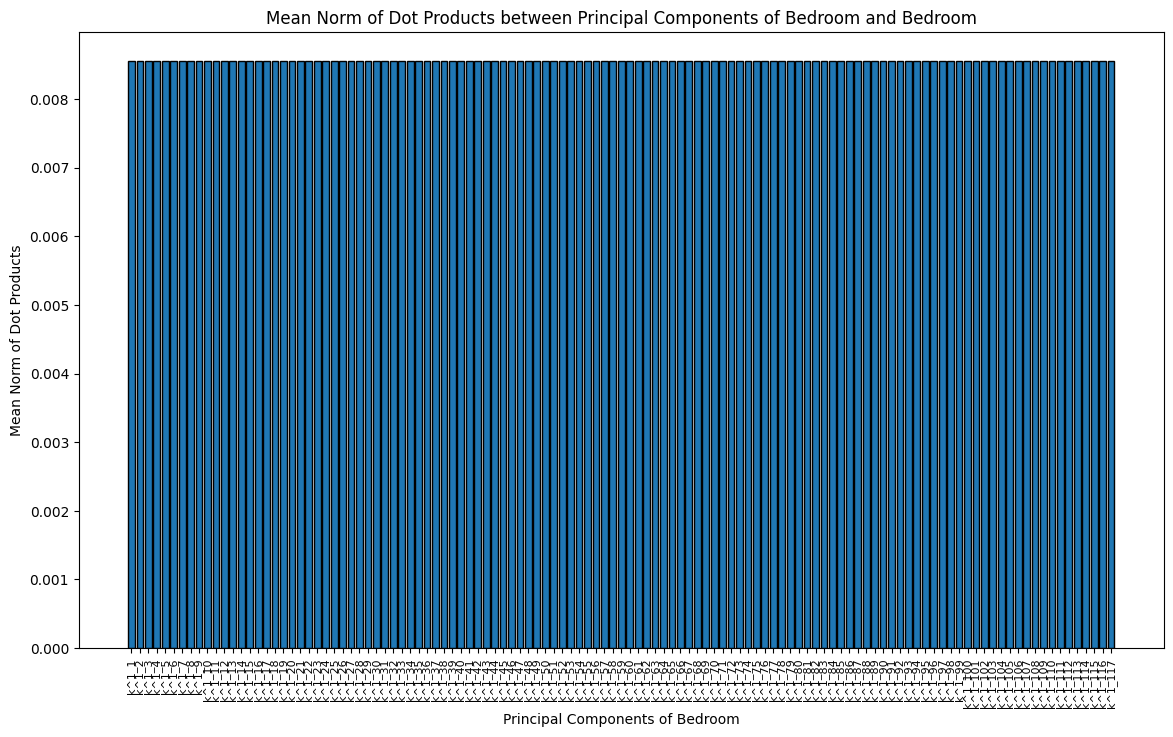

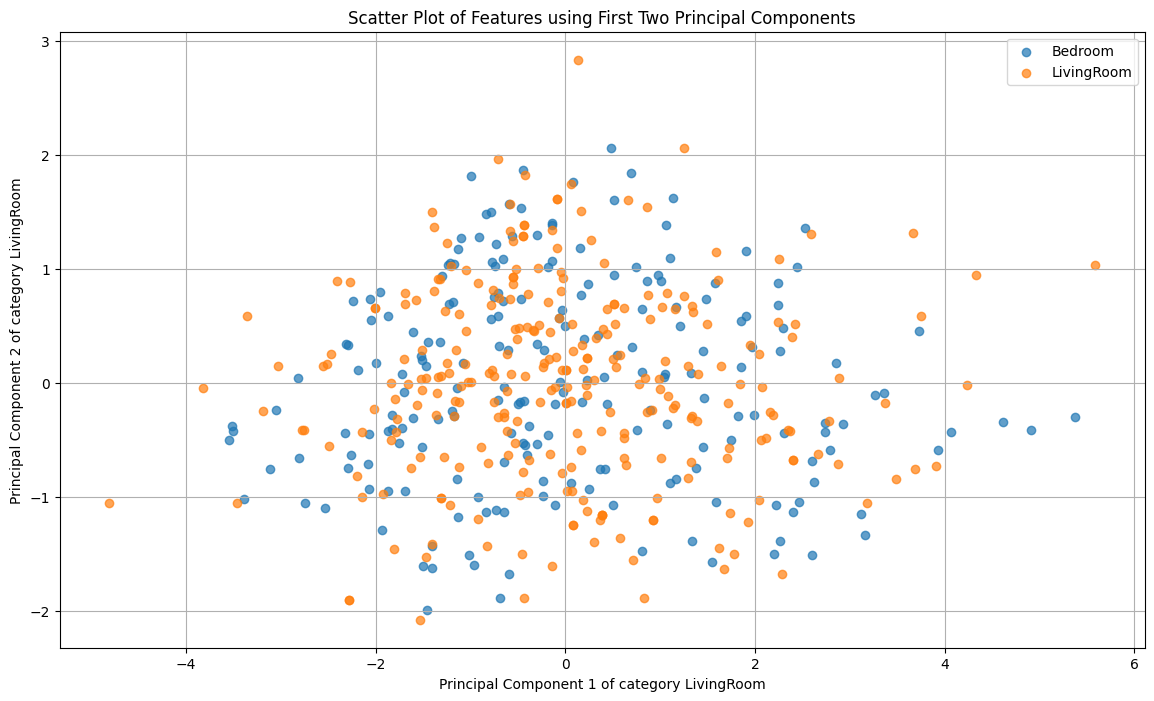

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Função para centralizar os dados
def centralize_data(data):
    centralized_data = data - np.mean(data, axis=0)
    return centralized_data

# Função para calcular a média das normas dos produtos escalares entre componentes principais
def calculate_mean_dot_product_norms(pca_components1, pca_components2):
    norms = []
    for component1 in pca_components1:
        norms_for_component = []
        for component2 in pca_components2:
            dot_product = np.dot(component1, component2)
            norms_for_component.append(np.linalg.norm(dot_product))
        mean_norm = np.mean(norms_for_component)
        norms.append(mean_norm)
    return np.array(norms)

# Função para plotar as normas dos produtos escalares para cada componente de component1
def plot_mean_dot_product_norms(norms, category1, category2):
    x_labels = [f'k^1_{i+1}' for i in range(len(norms))]
    plt.figure(figsize=(14, 8))
    plt.bar(x_labels, norms, edgecolor='black')
    plt.xlabel(f'Principal Components of {category1}')
    plt.ylabel('Mean Norm of Dot Products')
    plt.title(f'Mean Norm of Dot Products between Principal Components of {category1} and {category2}')
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

# Verificação das features
def verify_features(features):
    print("Shape of features:", features.shape)
    print("Mean of features (should be close to 0 if centralized):", np.mean(features, axis=0)[:10])
    print("Variance of features:", np.var(features, axis=0)[:10])



categories = ["Bedroom", "Bedroom"]

# Centralizar os dados
centralized_features_by_category = {category: centralize_data(features) for category, features in features_by_category.items()}

# Verificar as features centralizadas
for category, features in centralized_features_by_category.items():
    print(f"Verifying features for category: {category}")
    verify_features(features)

# Aplicar PCA
pca_by_category = {category: PCA(n_components=0.95).fit(features) for category, features in centralized_features_by_category.items()}

# Verificar componentes principais
for category, pca in pca_by_category.items():
    print(f"Explained variance ratio for category {category} (first 10 components): {pca.explained_variance_ratio_[:10]}")
    print(f"Components shape for category {category}: {pca.components_.shape}")

# Calcular e plotar a média das normas dos produtos escalares entre os componentes principais de diferentes espaços
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        category1 = categories[i]
        category2 = categories[j]
        norms = calculate_mean_dot_product_norms(pca_by_category[category1].components_, pca_by_category[category2].components_)
        plot_mean_dot_product_norms(norms, category1, category2)

# Scatter plot para visualização das features usando os dois primeiros componentes principais
def plot_pca_scatter(features_by_category, pca_by_category):
    plt.figure(figsize=(14, 8))
    for category, features in features_by_category.items():
        transformed_features = pca_by_category[category].transform(features)
        plt.scatter(transformed_features[:, 0], transformed_features[:, 1], label=category, alpha=0.7)
    plt.xlabel(f'Principal Component 1 of category {category}')
    plt.ylabel(f'Principal Component 2 of category {category}')
    plt.title('Scatter Plot of Features using First Two Principal Components')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar o scatter plot
plot_pca_scatter(centralized_features_by_category, pca_by_category)


Verifying features for category: Bedroom
Shape of features: (207, 4096)
Mean of features (should be close to 0 if centralized): [-7.7673199e-08 -2.7966673e-08 -1.3677395e-09  1.3989522e-11
  0.0000000e+00  0.0000000e+00 -1.1715768e-08 -7.6485429e-11
  7.6305460e-09 -4.5495334e-08]
Variance of features: [5.1907590e-03 2.0372779e-03 2.8934216e-04 5.9595823e-07 0.0000000e+00
 0.0000000e+00 2.6187797e-03 6.9380681e-06 4.0604873e-03 5.9186928e-03]
Verifying features for category: LivingRoom
Shape of features: (278, 4096)
Mean of features (should be close to 0 if centralized): [ 2.8006680e-08  1.1376875e-08  1.2462302e-09  0.0000000e+00
 -6.0144424e-11  0.0000000e+00  1.6670004e-08 -2.1566148e-11
 -7.1691737e-09 -9.2730247e-08]
Variance of features: [4.2505441e-03 1.7409398e-03 3.6224400e-04 0.0000000e+00 1.1884508e-06
 0.0000000e+00 2.7382111e-03 2.0425223e-06 3.0124257e-03 5.1002507e-03]


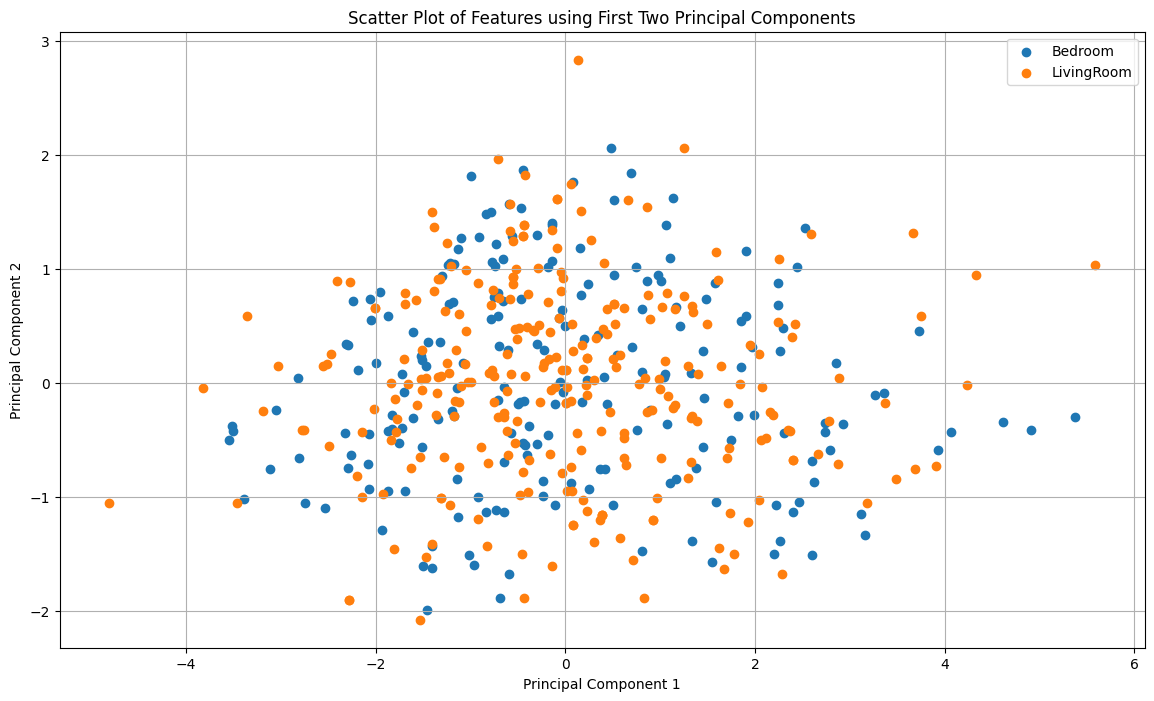

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Função para centralizar os dados
def centralize_data(data):
    centralized_data = data - np.mean(data, axis=0)
    return centralized_data

# Supondo que 'features_by_category' seja um dicionário contendo os dados das características para cada categoria
# Exemplo: features_by_category = {'Bedroom': array_de_caracteristicas, 'LivingRoom': array_de_caracteristicas}

categories = ['Bedroom', 'LivingRoom']

# Centralizar os dados
centralized_features_by_category = {category: centralize_data(features) for category, features in features_by_category.items()}

# Verificar as features centralizadas
for category, features in centralized_features_by_category.items():
    print(f"Verifying features for category: {category}")
    verify_features(features)

# Aplicar PCA e reduzir para 2 componentes
pca_by_category_2d = {category: PCA(n_components=2).fit_transform(centralized_features) for category, centralized_features in centralized_features_by_category.items()}

# Plotar os dados
plt.figure(figsize=(14, 8))

for category, pca_data in pca_by_category_2d.items():
    plt.scatter(pca_data[:, 0], pca_data[:, 1], label=category)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Features using First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_centralized_images_by_category = {}

    for category, images in test_images_by_category.items():
        test_centralized_images  = center_images(images)
        test_centralized_images_by_category[category] = test_centralized_images

    return test_centralized_images_by_category

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size)


NameError: name 'input_size' is not defined

In [ ]:
def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


4/4 [==============================] - 8s 2s/step


In [ ]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        # Calcular o erro de reconstrução
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.015176227316260338
Category LivingRoom, mean reconstruction error: 0.020946694537997246
Best category: Bedroom
Test category: LivingRoom
Category Bedroom, mean reconstruction error: 0.018958861008286476
Category LivingRoom, mean reconstruction error: 0.011677606031298637
Best category: LivingRoom


## Agnostic Spaces

In [ ]:
# Get the Principal Components from both categories
# First, we're going to test for "bedroom" and "livingroom"

pca_bedroom = pca_by_category['Bedroom']
components_bedroom = pca_bedroom.components_
explained_variance_ratio_bedroom = pca_bedroom.explained_variance_ratio_


pca_livingroom = pca_by_category['LivingRoom']
components_livingroom = pca_livingroom.components_
explained_variance_ratio_livingroom = pca_livingroom.explained_variance_ratio_

print(components_livingroom.shape)
print(components_bedroom.shape)

(174, 4096)
(138, 4096)


Shape of components_coast: (170, 4096)


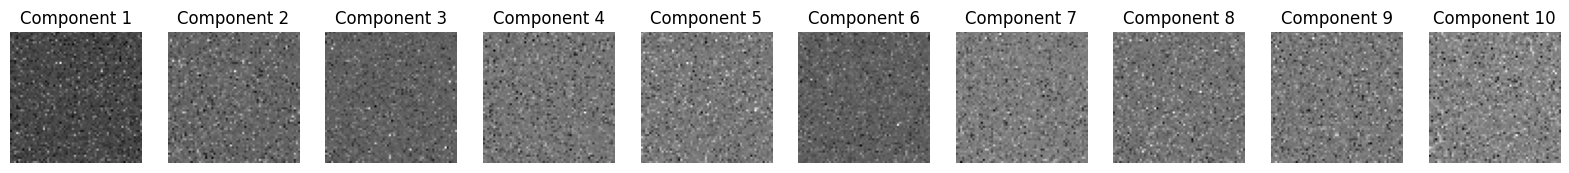

In [ ]:
# Verifique a forma do array
print("Shape of components_coast:", components_coast.shape)

# Supondo que cada componente tem 4096 valores (64x64 pixels)
image_size = (64, 64)

# Visualizar os primeiros 10 componentes principais como imagens
num_components_to_show = 10
fig, axes = plt.subplots(1, num_components_to_show, figsize=(20, 4))
for i in range(num_components_to_show):
    component_image = components_coast[i].reshape(image_size)
    axes[i].imshow(component_image, cmap='gray')
    axes[i].set_title(f'Component {i+1}')
    axes[i].axis('off')

plt.show()

In [ ]:
norms_of_means_bedroom = []

for component in components_bedroom:
    dot_products = np.dot(components_livingroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_bedroom.append(norm_of_mean)

norms_of_means_bedroom = np.array(norms_of_means_bedroom)

norms_of_means_bedroom_bedroom = []

for component in components_bedroom:
    dot_products = np.dot(components_bedroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_bedroom_bedroom.append(norm_of_mean)

norms_of_means_bedroom_bedroom = np.array(norms_of_means_bedroom_bedroom)

norms_of_means_livingroom_livingroom = []

for component in components_livingroom:
    dot_products = np.dot(components_livingroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_livingroom_livingroom.append(norm_of_mean)

norms_of_means_livingroom_livingroom = np.array(norms_of_means_livingroom_livingroom)

norms_of_means_livingroom = []

for component in components_livingroom:
    dot_products = np.dot(components_bedroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_livingroom.append(norm_of_mean)

norms_of_means_livingroom = np.array(norms_of_means_livingroom)

Shape of components_coast: (170, 4096)
[[-0.00076625 -0.00280339 -0.01703191 ...  0.00809747  0.01750076
  -0.00156438]
 [-0.00031595 -0.00379452  0.00856033 ... -0.03205795  0.01491567
   0.00518089]
 [-0.00070089  0.00421602 -0.03095886 ... -0.02308915 -0.00127031
  -0.00481359]
 ...
 [-0.00352324 -0.0052019  -0.00428228 ...  0.03547398  0.01159483
  -0.00868903]
 [-0.00579386 -0.02066827 -0.0061619  ...  0.00670531  0.06782439
   0.0113829 ]
 [-0.0188157  -0.00010631 -0.00989175 ...  0.03106171  0.00733281
  -0.00788716]]
[[ 0.05400132  0.02118707 -0.0007447  ...  0.01075882  0.00954271
   0.02161119]
 [ 0.01644632  0.00350946  0.00189982 ...  0.01628574 -0.01512819
  -0.00079993]
 [-0.03749105 -0.00098777 -0.00099939 ... -0.04021334 -0.02581021
  -0.00604224]
 ...
 [ 0.00386551  0.01284663 -0.0041475  ... -0.00930471 -0.01679436
  -0.01099295]
 [-0.01221646 -0.01402397 -0.00174974 ... -0.00848403  0.00811937
   0.01404397]
 [-0.00100505 -0.00497847 -0.0053246  ... -0.00717768 -0.01

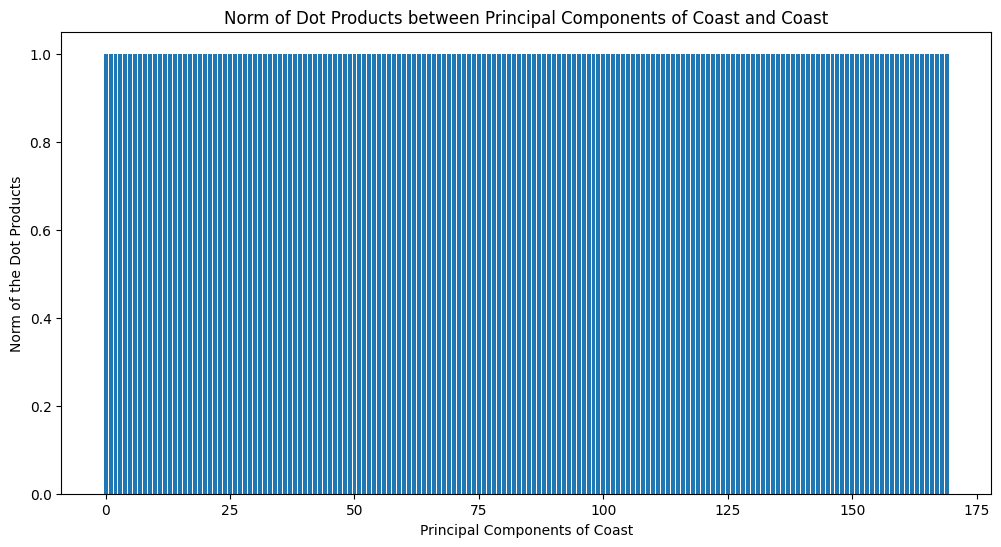

In [ ]:
# Verifique a forma do array
print("Shape of components_coast:", components_coast.shape)

# Inicialize a lista para armazenar as normas dos produtos internos médios
norms_of_means_coast_coast = []

print(components_coast)
print("===================================")
print(components_bedroom)

# Calcule os produtos internos e suas normas
for component in components_coast:
    dot_products = np.dot(components_coast, component)
    norm_of_dot_products = np.linalg.norm(dot_products)
    norms_of_means_coast_coast.append(norm_of_dot_products)

# Converter a lista para um array numpy para facilitar a plotagem
norms_of_means_coast_coast = np.array(norms_of_means_coast_coast)

# Verificar os valores calculados
print("Norms of dot products coast-coast:", norms_of_means_coast_coast)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.bar(range(len(norms_of_means_coast_coast)), norms_of_means_coast_coast)
plt.xlabel('Principal Components of Coast')
plt.ylabel('Norm of the Dot Products')
plt.title('Norm of Dot Products between Principal Components of Coast and Coast')
plt.show()


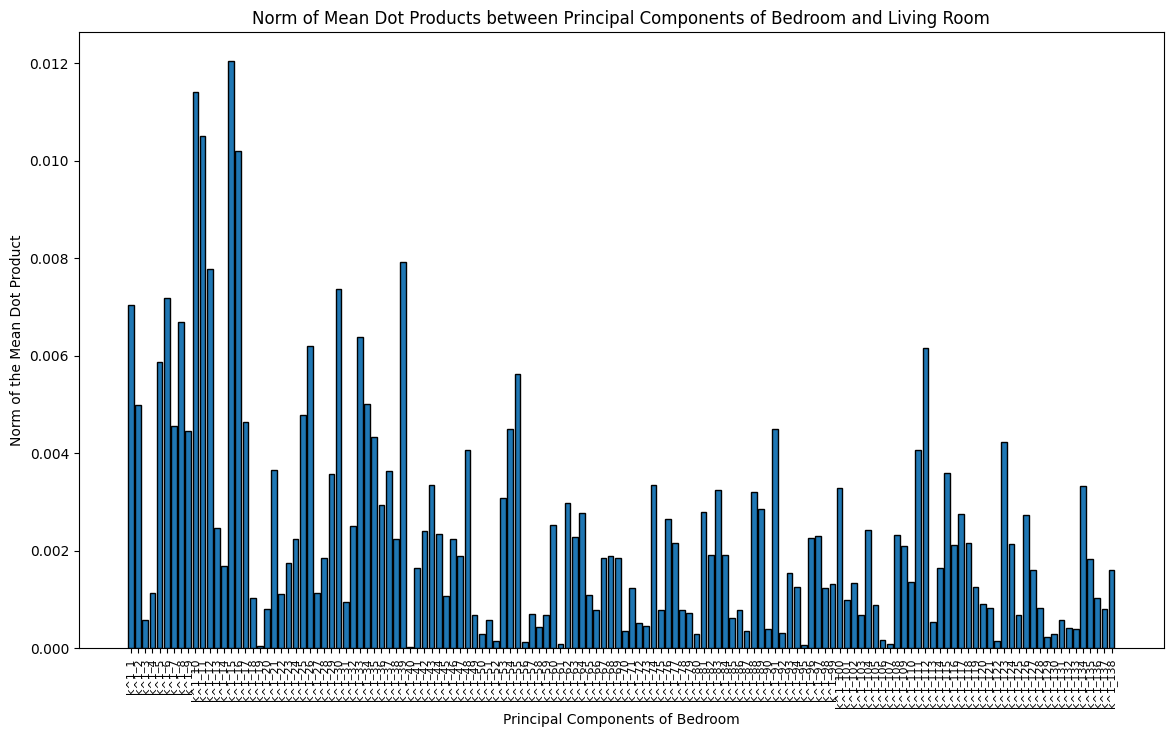

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_bedroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_bedroom, edgecolor='black')
plt.xlabel('Principal Components of Bedroom')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Bedroom and Living Room')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


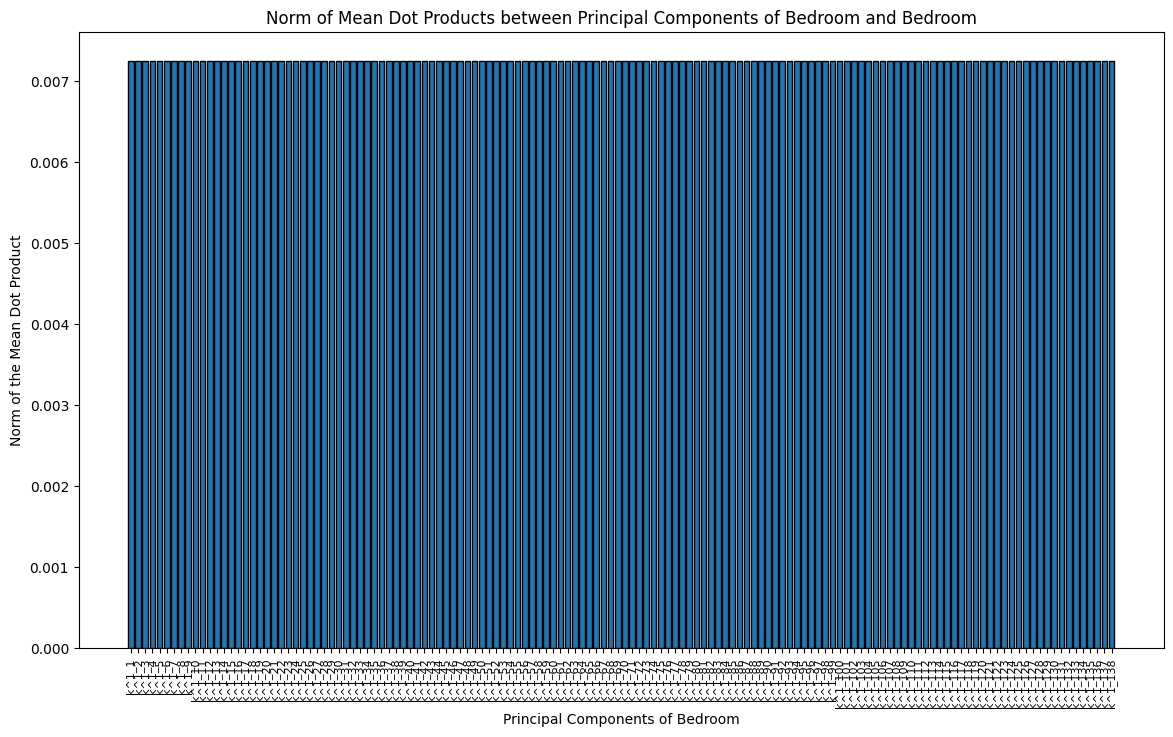

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_bedroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_bedroom_bedroom, edgecolor='black')
plt.xlabel('Principal Components of Bedroom')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Bedroom and Bedroom')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


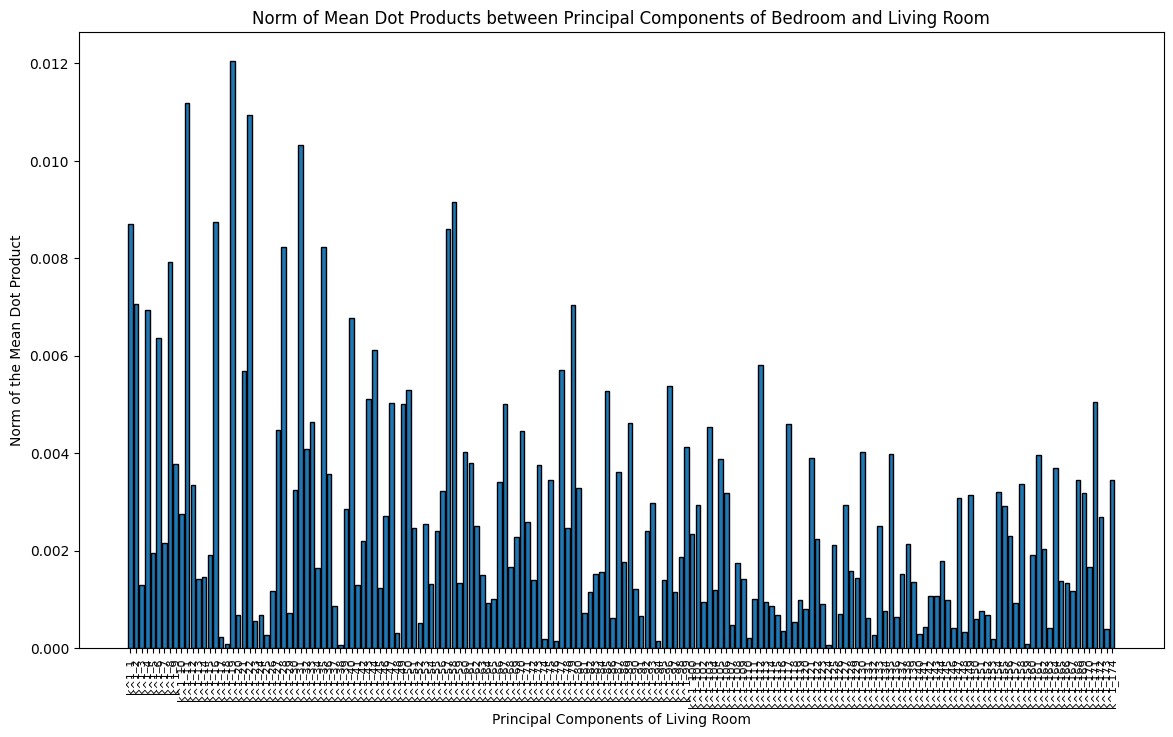

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_livingroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_livingroom, edgecolor='black')
plt.xlabel('Principal Components of Living Room')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Bedroom and Living Room')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


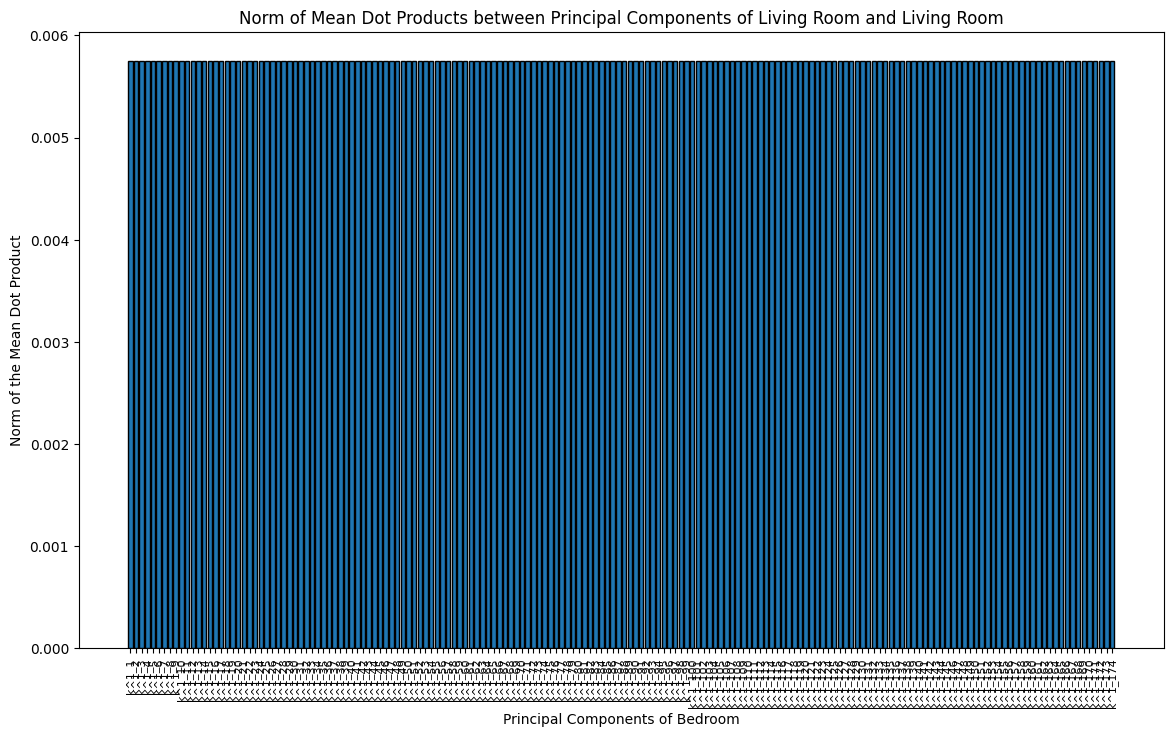

In [ ]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_livingroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_livingroom_livingroom, edgecolor='black')
plt.xlabel('Principal Components of Bedroom')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Living Room and Living Room')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


In [ ]:
threshold_percentile = 10

threshold_value_bedroom = np.percentile(norms_of_means_bedroom, threshold_percentile)
threshold_value_livingroom = np.percentile(norms_of_means_livingroom, threshold_percentile)

# Get the indices with the smallest values
specific_indices_bedroom = np.where(norms_of_means_bedroom <= threshold_value_bedroom)[0]
specific_indices_livingroom = np.where(norms_of_means_livingroom <= threshold_value_livingroom)[0]

print("Specific Indices for Bedroom:", specific_indices_bedroom + 1)
print("Specific Indices for Living Room:", specific_indices_livingroom + 1)

Specific Indices for Bedroom: [ 19  40  50  52  56  61  80  92  95 106 107 122 129 130]
Specific Indices for Living Room: [ 17  18  25  38  48  74  76  94 110 116 124 132 140 148 153 159 163 173]


In [ ]:
test_bedroom_features = test_features_by_category['Bedroom']
test_livingroom_features = test_features_by_category['LivingRoom']

print(test_bedroom_features.shape)
print(test_livingroom_features.shape)

(78, 4096)
(101, 4096)


In [ ]:
specific_components_bedroom = pca_bedroom.components_[specific_indices_bedroom]
specific_components_livingroom = pca_livingroom.components_[specific_indices_livingroom]

for i, index in enumerate(specific_indices_bedroom):
    print(f"Component {index + 1}: {np.array_equal(components_bedroom[index], specific_components_bedroom[i])}")

print("==================")

for i, index in enumerate(specific_indices_livingroom):
    print(f"Component {index + 1}: {np.array_equal(components_livingroom[index], specific_components_livingroom[i])}")


Component 19: True
Component 40: True
Component 50: True
Component 52: True
Component 56: True
Component 61: True
Component 80: True
Component 92: True
Component 95: True
Component 106: True
Component 107: True
Component 122: True
Component 129: True
Component 130: True
Component 17: True
Component 18: True
Component 25: True
Component 38: True
Component 48: True
Component 74: True
Component 76: True
Component 94: True
Component 110: True
Component 116: True
Component 124: True
Component 132: True
Component 140: True
Component 148: True
Component 153: True
Component 159: True
Component 163: True
Component 173: True


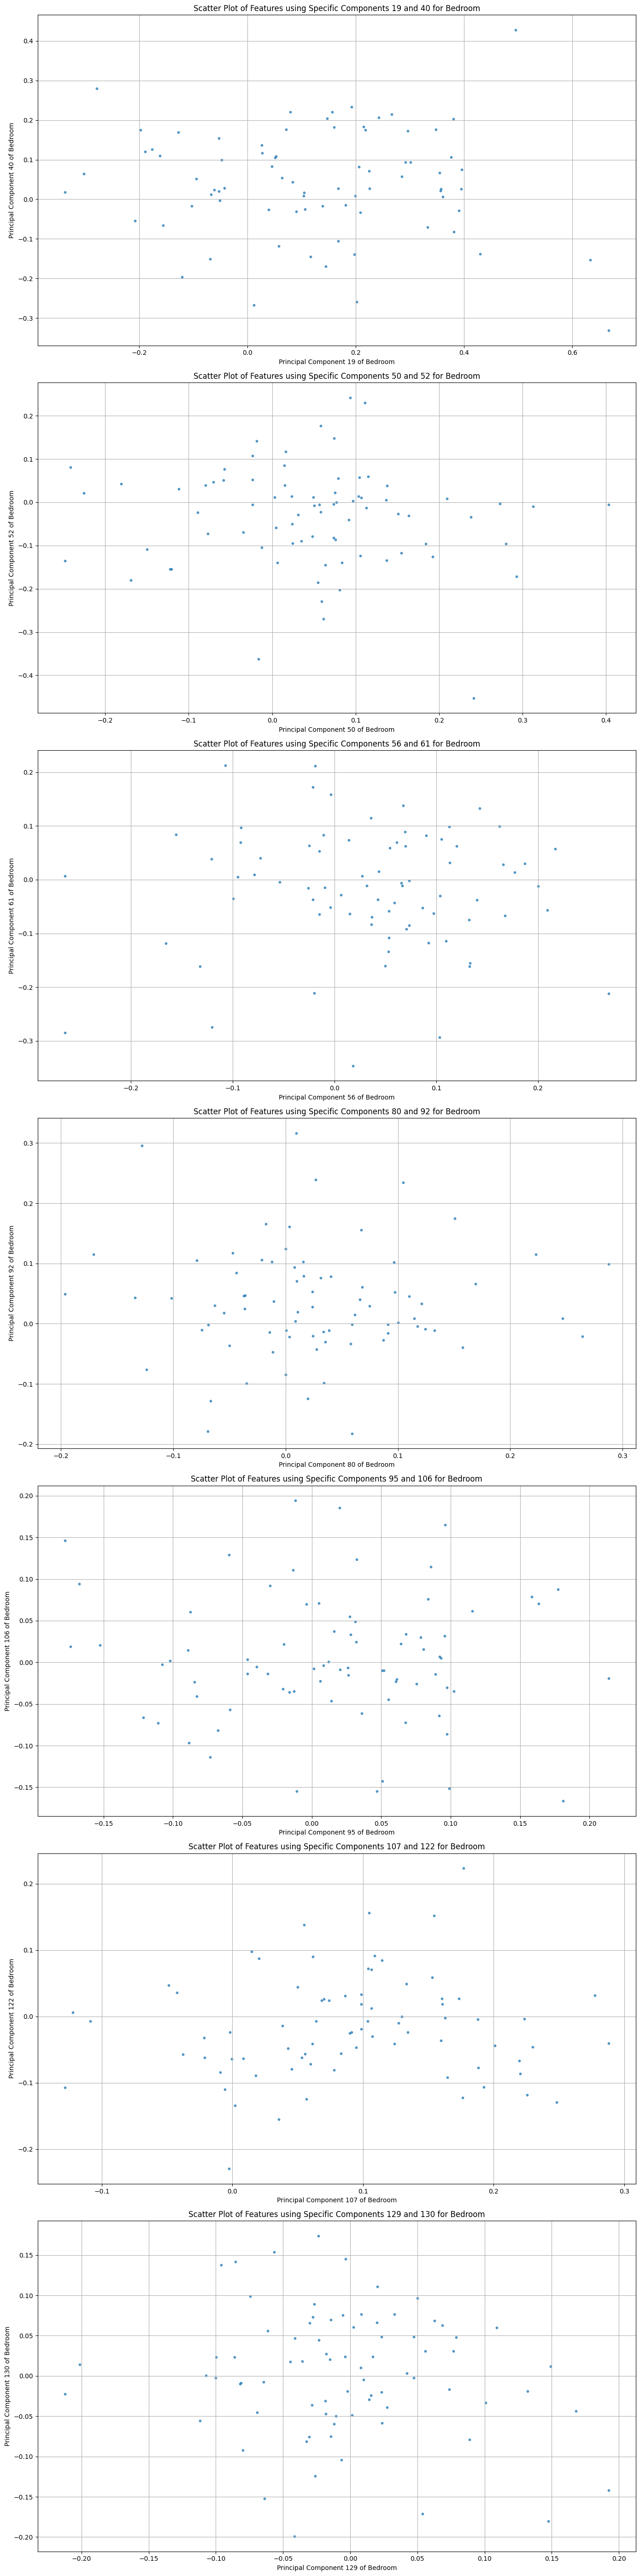

In [ ]:
import matplotlib.pyplot as plt

def plot_features_with_specific_components_subplots(features, pca, specific_indices, category):
    num_plots = len(specific_indices) // 2
    fig, axs = plt.subplots(num_plots, figsize=(14, 8 * num_plots))

    for i in range(num_plots):
        idx1 = specific_indices[2 * i]
        idx2 = specific_indices[2 * i + 1]
        transformed_features = features.dot(pca.components_[[idx1, idx2]].T)
        
        ax = axs[i] if num_plots > 1 else axs
        ax.scatter(transformed_features[:, 0], transformed_features[:, 1], alpha=0.7, s=10)
        ax.set_xlabel(f'Principal Component {idx1 + 1} of {category}')
        ax.set_ylabel(f'Principal Component {idx2 + 1} of {category}')
        ax.set_title(f'Scatter Plot of Features using Specific Components {idx1 + 1} and {idx2 + 1} for {category}')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Supondo que você já tenha os componentes principais e os índices específicos calculados
# e que tenha o dicionário test_features_by_category e pca_by_category

# Escolher uma categoria para plotar
category = 'Bedroom'
specific_indices = specific_indices_bedroom  # Usar todos os índices específicos

# Chamar a função com as features de teste
plot_features_with_specific_components_subplots(test_features_by_category[category], pca_by_category[category], specific_indices, category)


In [ ]:
def project_and_reconstruct(original_features, specific_components):
    # Flatten the original features
    flattened_features = np.array([feature.flatten() for feature in original_features])
    
    # Project the data into the specific components
    projected_features = np.dot(flattened_features, specific_components.T)
    
    # Reconstruct the features
    reconstructed_features = np.dot(projected_features, specific_components)
    
    # Reshape the reconstructed features into the original shape
    reconstructed_features = reconstructed_features.reshape(original_features.shape)
    
    return reconstructed_features

reconstructed_test_bedroom_bedroom_images = project_and_reconstruct(test_bedroom_features, specific_components_bedroom)
reconstructed_test_bedroom_livingroom_images = project_and_reconstruct(test_bedroom_features, specific_components_livingroom)

print("Reconstructed Test Bedroom Images (using Bedroom components):", reconstructed_test_bedroom_bedroom_images)
print("Reconstructed Test Bedroom Images (using Bedroom components):", reconstructed_test_bedroom_bedroom_images.shape)
print("Reconstructed Test Bedroom Images (using Living Room components):", reconstructed_test_bedroom_livingroom_images)
print("Reconstructed Test Bedroom Images (using Living Room components):", reconstructed_test_bedroom_livingroom_images.shape)

reconstructed_test_livingroom_bedroom_images = project_and_reconstruct(test_livingroom_features, specific_components_bedroom)
reconstructed_test_livingroom_livingroom_images = project_and_reconstruct(test_livingroom_features, specific_components_livingroom)

print("Reconstructed Test Living Room Images (using Bedroom components):", reconstructed_test_livingroom_bedroom_images)
print("Reconstructed Test Living Room Images (using Bedroom components):", reconstructed_test_livingroom_bedroom_images.shape)
print("Reconstructed Test Living Room Images (using Living Room components):", reconstructed_test_livingroom_livingroom_images)
print("Reconstructed Test Living Room Images (using Living Room components):", reconstructed_test_livingroom_livingroom_images.shape)


Reconstructed Test Bedroom Images (using Bedroom components): [[ 8.2663894e-03 -9.3435403e-03  4.3277076e-04 ...  1.1841205e-02
  -5.5589755e-03 -2.0617513e-02]
 [ 1.2240037e-03 -1.2484277e-02  5.8583533e-05 ...  4.3805903e-03
  -1.4389765e-03 -1.3361927e-02]
 [ 1.4772117e-03 -4.1963095e-03  2.2718506e-03 ... -3.5767334e-03
  -8.5529797e-03 -7.3577771e-03]
 ...
 [ 6.8076281e-04 -9.4941109e-03 -1.4723878e-03 ...  1.6151458e-02
  -8.0024302e-03 -5.9495056e-03]
 [-1.3395660e-03 -3.7302398e-03  3.4069992e-04 ...  2.2503403e-03
  -8.7736603e-03  1.1599977e-03]
 [-6.1198366e-03 -6.6370810e-03  2.2383418e-03 ... -1.1760845e-02
  -1.6858671e-03 -1.4366552e-02]]
Reconstructed Test Bedroom Images (using Bedroom components): (78, 4096)
Reconstructed Test Bedroom Images (using Living Room components): [[ 5.81834093e-03  5.28019946e-03 -1.72450091e-03 ...  6.38043694e-03
   2.93814554e-03 -5.94368530e-03]
 [-2.14473880e-03 -5.51963504e-03 -9.64849722e-04 ...  8.67810007e-03
  -1.93411915e-03 -1.168

In [ ]:
residuals_bedroom_bedroom = test_bedroom_features - reconstructed_test_bedroom_bedroom_images
residuals_bedroom_livingroom = test_bedroom_features - reconstructed_test_bedroom_livingroom_images

residuals_livingroom_bedroom = test_livingroom_features - reconstructed_test_livingroom_livingroom_images
residuals_livingroom_livingroom = test_livingroom_features - reconstructed_test_livingroom_livingroom_images

print("Residuals Bedroom-Bedroom:", residuals_bedroom_bedroom)
print("Residuals Bedroom-Living Room:", residuals_bedroom_livingroom)
print("Residuals Living Room-Bedroom:", residuals_livingroom_bedroom)
print("Residuals Living Room-Living Room:", residuals_livingroom_livingroom)

Residuals Bedroom-Bedroom: [[ 4.40321505e-01  2.19833449e-01 -4.32770757e-04 ...  3.84954773e-02
   9.09357965e-02  2.22171739e-01]
 [ 5.25622964e-01  2.61727422e-01 -5.85835332e-05 ...  1.10689208e-01
   1.62370130e-01  1.86559618e-01]
 [ 3.83070320e-01  1.98020712e-01 -2.27185059e-03 ...  7.15809688e-02
   8.05959105e-02  1.17228307e-01]
 ...
 [ 4.41415191e-01  2.05187574e-01  1.47238781e-03 ...  1.05376221e-01
   8.00243020e-03  1.20794795e-01]
 [ 3.98309231e-01  1.78080380e-01 -3.40699917e-04 ...  5.46007939e-02
   7.85532743e-02  2.66428202e-01]
 [ 4.14634913e-01  1.97747931e-01 -2.23834184e-03 ...  1.89796820e-01
   9.72603485e-02  8.50447863e-02]]
Residuals Bedroom-Living Room: [[ 4.42769557e-01  2.05209717e-01  1.72450091e-03 ...  4.39562425e-02
   8.24386775e-02  2.07497910e-01]
 [ 5.28991699e-01  2.54762799e-01  9.64849722e-04 ...  1.06391698e-01
   1.62865281e-01  1.84883952e-01]
 [ 3.92439157e-01  1.99748382e-01  7.94764899e-04 ...  6.10840209e-02
   7.18913376e-02  1.10144

In [ ]:
def calculate_ood(original_features, residuals):
    residual_norms = np.linalg.norm(residuals, axis=1)
    original_norms = np.linalg.norm(original_features, axis=1)
    ood_scores = residual_norms / original_norms
    return ood_scores

In [ ]:

ood_scores_bedroom_bedroom = calculate_ood(test_bedroom_features, residuals_bedroom_bedroom)
ood_scores_bedroom_livingroom = calculate_ood(test_bedroom_features, residuals_bedroom_livingroom)

ood_scores_livingroom_bedroom = calculate_ood(test_livingroom_features, residuals_livingroom_bedroom)
ood_scores_livingroom_livingroom = calculate_ood(test_livingroom_features, residuals_livingroom_livingroom)

print("OOD Scores Bedroom-Bedroom:", ood_scores_bedroom_bedroom)
print("OOD Scores Bedroom-Living Room:", ood_scores_bedroom_livingroom)
print("OOD Scores Living Room-Living Room:", ood_scores_livingroom_livingroom)
print("OOD Scores Living Room-Bedroom:", ood_scores_livingroom_bedroom)



OOD Scores Bedroom-Bedroom: [0.9980406  0.99838406 0.9989225  0.9988343  0.9988114  0.99886584
 0.9991526  0.999004   0.99678093 0.9990474  0.9980357  0.9996262
 0.997606   0.9990743  0.99749726 0.9970094  0.9989857  0.997763
 0.9983084  0.99948794 0.9986577  0.99775666 0.9989064  0.99929565
 0.9969055  0.9968855  0.998582   0.99801564 0.9985538  0.9986995
 0.997317   0.99782705 0.99634683 0.9974681  0.9987979  0.9994451
 0.997762   0.9989956  0.9987431  0.9986348  0.998243   0.99903303
 0.9981637  0.9967434  0.99776244 0.99676776 0.9984881  0.99807125
 0.9991939  0.9983042  0.99845666 0.9993141  0.9980736  0.9982302
 0.9994265  0.9981181  0.99620885 0.9989887  0.9973851  0.998734
 0.9982739  0.998886   0.99804646 0.9983283  0.99866647 0.99843895
 0.9988411  0.99905074 0.9983747  0.9986457  0.9975511  0.9981147
 0.99824715 0.9989726  0.9974315  0.9972657  0.9994771  0.99714506]
OOD Scores Bedroom-Living Room: [0.9993204  0.99904156 0.9991152  0.99689096 0.9994017  0.9993341
 0.99798864

In [ ]:
ood_scores_bedroom = {
    'bedroom-bedroom': np.mean(ood_scores_bedroom_bedroom),
    'bedroom-livingroom': np.mean(ood_scores_bedroom_livingroom)
}
ood_scores_livingroom = {
    'livingroom-livingroom': np.mean(ood_scores_livingroom_livingroom),
    'livingroom-bedroom': np.mean(ood_scores_livingroom_bedroom)
}

best_environment_bedroom = min(ood_scores_bedroom, key=ood_scores_bedroom.get)
best_environment_livingroom = min(ood_scores_livingroom, key=ood_scores_livingroom.get)

print(f"OOD scores (Bedroom TEST): {ood_scores_bedroom}")
print(f"Best environment (Bedroom TEST): {best_environment_bedroom}")

print(f"OOD scores (Living Room TEST): {ood_scores_livingroom}")
print(f"Best environment (Living Room TEST): {best_environment_livingroom}")

OOD scores (Bedroom TEST): {'bedroom-bedroom': 0.99828583, 'bedroom-livingroom': 0.9985471}
Best environment (Bedroom TEST): bedroom-bedroom
OOD scores (Living Room TEST): {'livingroom-livingroom': 0.99783534, 'livingroom-bedroom': 0.99783534}
Best environment (Living Room TEST): livingroom-livingroom


## Malahanobis Distance Analysis

In [ ]:
from scipy.spatial.distance import mahalanobis

def calculate_mahalanobis_distance(features, mean, cov_inv):
    distances = []
    for feature in features:
        distance = mahalanobis(feature, mean, cov_inv)
        distances.append(distance)
    return np.array(distances)

def calculate_mean_cov(features):
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    cov += np.eye(cov.shape[0])
    cov_inv = np.linalg.inv(cov)
    return mean, cov_inv

train_bedroom_features = features_by_category['Bedroom']
train_livingroom_features = features_by_category['LivingRoom']

mean_bedroom, cov_inv_bedroom = calculate_mean_cov(train_bedroom_features)
mean_livingroom, cov_inv_livingroom = calculate_mean_cov(train_livingroom_features)

mahalanobis_distances_bedroom_bedroom = calculate_mahalanobis_distance(test_bedroom_features, mean_bedroom, cov_inv_bedroom)
mahalanobis_distances_bedroom_livingroom = calculate_mahalanobis_distance(test_bedroom_features, mean_livingroom, cov_inv_livingroom)

mahalanobis_distances_livingroom_livingroom = calculate_mahalanobis_distance(test_livingroom_features, mean_livingroom, cov_inv_livingroom)
mahalanobis_distances_livingroom_bedroom = calculate_mahalanobis_distance(test_livingroom_features, mean_bedroom, cov_inv_bedroom)


In [ ]:
ood_scores_bedroom_mahalanobis = {
    'bedroom-bedroom': np.mean(mahalanobis_distances_bedroom_bedroom),
    'bedroom-livingroom': np.mean(mahalanobis_distances_bedroom_livingroom)
}
ood_scores_livingroom_mahalanobis = {
    'livingroom-livingroom': np.mean(mahalanobis_distances_livingroom_livingroom),
    'livingroom-bedroom': np.mean(mahalanobis_distances_livingroom_bedroom)
}

best_environment_bedroom = min(ood_scores_bedroom_mahalanobis, key=ood_scores_bedroom_mahalanobis.get)
best_environment_livingroom = min(ood_scores_livingroom_mahalanobis, key=ood_scores_livingroom_mahalanobis.get)

print(f"OOD scores (bedroom TEST) MAHALANOBIS: {ood_scores_bedroom_mahalanobis}")
print(f"Best environment (bedroom TEST): {best_environment_bedroom}")

print(f"OOD scores (livingroom TEST) MAHALANOBIS: {ood_scores_livingroom_mahalanobis}")
print(f"Best environment (livingroom TEST): {best_environment_livingroom}")

OOD scores (bedroom TEST) MAHALANOBIS: {'bedroom-bedroom': 2.0918188419563384, 'bedroom-livingroom': 2.160111220408669}
Best environment (bedroom TEST): bedroom-bedroom
OOD scores (livingroom TEST) MAHALANOBIS: {'livingroom-livingroom': 2.115076387388355, 'livingroom-bedroom': 2.158481196539797}
Best environment (livingroom TEST): livingroom-livingroom


## All environments

In [ ]:
X = df['image_path'].tolist()
y = df['category'].tolist()
unique_categories = list(df['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 'Office', 'Store']


In [ ]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [ ]:
all_test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size)

KeyboardInterrupt: 

In [ ]:
all_test_features_by_category = extract_features_with_vgg16(model, all_test_preprocessed_images_by_category)

2024-07-24 09:20:25.979116: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,2048], In[1]: [25088,4096]
	 [[{{node model_1/fc1/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/fc1/Relu' defined at (most recent call last):
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/runpy.py", line 198, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/runpy.py", line 88, in _run_code
      exec(code, run_globals)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7140/3459881574.py", line 1, in <module>
      all_test_features_by_category = extract_features_with_vgg16(model, all_test_preprocessed_images_by_category)
    File "/tmp/ipykernel_7140/492376533.py", line 4, in extract_features_with_vgg16
      features = model.predict(images)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/contente/anaconda3/envs/os202/lib/python3.11/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model_1/fc1/Relu'
Matrix size-incompatible: In[0]: [32,2048], In[1]: [25088,4096]
	 [[{{node model_1/fc1/Relu}}]] [Op:__inference_predict_function_2384]

In [ ]:
all_training_preprocessed_images_by_category = load_and_preprocess_test_images('images_train', y, image_size, input_size)

In [ ]:
all_training_features_by_category = extract_features_with_vgg16(model, all_training_preprocessed_images_by_category)

8/8 [==============================] - 20s 3s/step


In [ ]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in all_training_features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")

Category Bedroom, principal components: 77
Category Suburb, principal components: 70
Category Industry, principal components: 74
Category Kitchen, principal components: 70
Category LivingRoom, principal components: 83
Category Coast, principal components: 66
Category Forest, principal components: 61
Category Highway, principal components: 59
Category InsideCity, principal components: 75
Category Mountain, principal components: 72
Category OpenCountry, principal components: 70
Category Street, principal components: 75
Category Building, principal components: 75
Category Office, principal components: 73
Category Store, principal components: 80
Category Bedroom, principal components shape: (77, 4096)
Category Bedroom, explained variance: 95.10%
Category Suburb, principal components shape: (70, 4096)
Category Suburb, explained variance: 95.12%
Category Industry, principal components shape: (74, 4096)
Category Industry, explained variance: 95.01%
Category Kitchen, principal components shape

In [ ]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in all_test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.0055860551074147224
Category Suburb, mean reconstruction error: 0.01466196309775114
Category Industry, mean reconstruction error: 0.01240596640855074
Category Kitchen, mean reconstruction error: 0.010530090890824795
Category LivingRoom, mean reconstruction error: 0.007999078370630741
Category Coast, mean reconstruction error: 0.019556384533643723
Category Forest, mean reconstruction error: 0.019378958269953728
Category Highway, mean reconstruction error: 0.01782098412513733
Category InsideCity, mean reconstruction error: 0.012468244880437851
Category Mountain, mean reconstruction error: 0.0181476678699255
Category OpenCountry, mean reconstruction error: 0.0188447292894125
Category Street, mean reconstruction error: 0.012417643330991268
Category Building, mean reconstruction error: 0.012196498923003674
Category Office, mean reconstruction error: 0.010740135796368122
Category Store, mean reconstruction error: 0.0104459

True category: Bedroom
Category Bedroom, mean reconstruction error: 0.0055860551074147224
Category Suburb, mean reconstruction error: 0.01466196309775114
Category Industry, mean reconstruction error: 0.01240596640855074
Category Kitchen, mean reconstruction error: 0.010530090890824795
Category LivingRoom, mean reconstruction error: 0.007999078370630741
Category Coast, mean reconstruction error: 0.019556384533643723
Category Forest, mean reconstruction error: 0.019378958269953728
Category Highway, mean reconstruction error: 0.01782098412513733
Category InsideCity, mean reconstruction error: 0.012468244880437851
Category Mountain, mean reconstruction error: 0.0181476678699255
Category OpenCountry, mean reconstruction error: 0.0188447292894125
Category Street, mean reconstruction error: 0.012417643330991268
Category Building, mean reconstruction error: 0.012196498923003674
Category Office, mean reconstruction error: 0.010740135796368122
Category Store, mean reconstruction error: 0.0104459

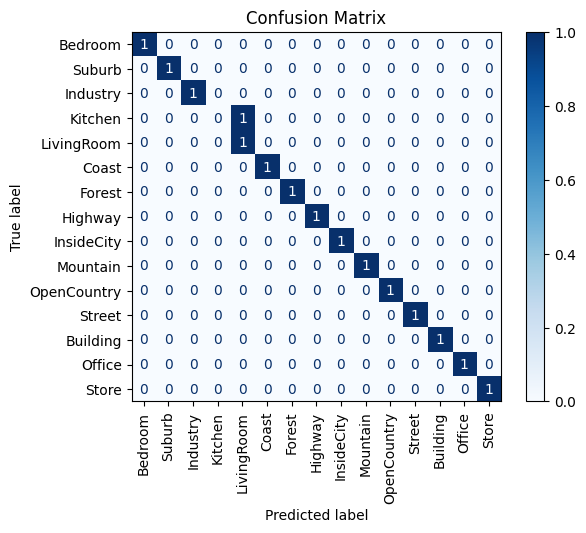

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_categories = []
predicted_categories = []

for true_category, test_features in all_test_features_by_category.items():
    print(f"True category: {true_category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)
    true_categories.append(true_category)
    predicted_categories.append(best_category)

labels = list(pca_by_category.keys())
cm = confusion_matrix(true_categories, predicted_categories, labels=labels)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

Category Bedroom, mean reconstruction error: 0.0055860551074147224
Category Suburb, mean reconstruction error: 0.01466196309775114
Category Industry, mean reconstruction error: 0.01240596640855074
Category Kitchen, mean reconstruction error: 0.010530090890824795
Category LivingRoom, mean reconstruction error: 0.007999078370630741
Category Coast, mean reconstruction error: 0.019556384533643723
Category Forest, mean reconstruction error: 0.019378958269953728
Category Highway, mean reconstruction error: 0.01782098412513733
Category InsideCity, mean reconstruction error: 0.012468244880437851
Category Mountain, mean reconstruction error: 0.0181476678699255
Category OpenCountry, mean reconstruction error: 0.0188447292894125
Category Street, mean reconstruction error: 0.012417643330991268
Category Building, mean reconstruction error: 0.012196498923003674
Category Office, mean reconstruction error: 0.010740135796368122
Category Store, mean reconstruction error: 0.010445995256304741
Best catego

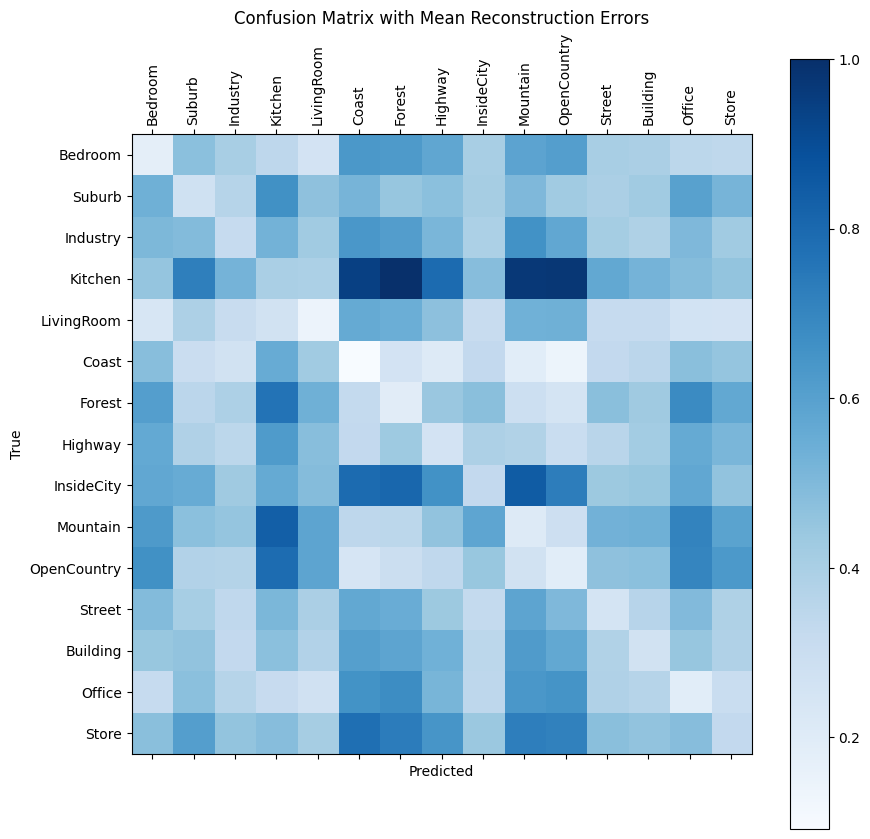

In [ ]:
labels = list(pca_by_category.keys())
confusion_matrix = np.zeros((len(labels), len(labels)))

for true_category, test_features in all_test_features_by_category.items():
    mean_reconstruction_errors, _ = calculate_reconstruction_error(test_features, pca_by_category)
    true_idx = labels.index(true_category)
    
    for pred_category, error in mean_reconstruction_errors.items():
        pred_idx = labels.index(pred_category)
        confusion_matrix[true_idx, pred_idx] = error

max_error = confusion_matrix.max()
confusion_matrix_normalized = confusion_matrix / max_error

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(confusion_matrix_normalized, cmap=plt.cm.Blues)
plt.colorbar(cax)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

plt.title('Discrimination Matrix with Mean Reconstruction Errors')
plt.xlabel('Latent Space')
plt.ylabel('Projection/Eigen Space')
plt.show()